In [1]:
import os; os.environ["CONDA_PREFIX"] = "/opt/conda"
!pip install -U -q uv

In [2]:
!uv pip install modAL-python torchvision torchmetrics mlxtend torchsummary scikit-learn-intelex torcheval

Resolved 47 packages in 406ms
Downloaded 16 packages in 1.22s
Installed 16 packages in 95ms
 - contourpy==1.2.0
 - contourpy==1.2.1 (from file:///home/conda/feedstock_root/build_artifacts/contourpy_1712429905637/work)
 + contourpy==1.2.0
 - fonttools==4.47.0
 - fonttools==4.51.0 (from file:///home/conda/feedstock_root/build_artifacts/fonttools_1712344558731/work)
 + fonttools==4.47.0
 - fsspec==2024.2.0
 - fsspec==2024.3.1 (from file:///home/conda/feedstock_root/build_artifacts/fsspec_1710808267764/work)
 + fsspec==2024.2.0
 - markupsafe==2.1.5
 - markupsafe==2.1.3 (from file:///home/conda/feedstock_root/build_artifacts/markupsafe_1695367434228/work)
 + markupsafe==2.1.5
 - matplotlib==3.7.5
 - matplotlib==3.8.4 (from file:///home/conda/feedstock_root/build_artifacts/matplotlib-suite_1712605966339/work)
 + matplotlib==3.7.5
 + modal-python==0.4.2.1
 - pandas==2.1.4
 - pandas==2.2.2
 + pandas==2.2.2
 - pillow==9.5.0
 - pillow==10.3.0 (from file:///home/conda/feedstock_root/build_artifac

# Imports


In [3]:
import random
import matplotlib.pyplot as plt
import mlxtend
import numpy as np
import torch
import torchvision
from torch import nn
from mlxtend.plotting import plot_confusion_matrix
from modAL.disagreement import vote_entropy_sampling
from modAL.models import ActiveLearner, Committee
from modAL.uncertainty import entropy_sampling, margin_sampling, uncertainty_sampling
from sklearnex import patch_sklearn
import warnings
from sklearn.linear_model import LogisticRegression
import tensorflow_hub as hub
from datasets import load_dataset
from torcheval.metrics.functional import (
    multiclass_accuracy,
    multiclass_confusion_matrix,
    multiclass_f1_score,
    multiclass_precision,
    multiclass_recall,
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

if not os.path.exists("reports"): os.mkdir("reports")
patch_sklearn()
print(f"mlxtend version: {mlxtend.__version__}")
print("torch", torch.__version__)
print("torchvision", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU List:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device())
warnings.filterwarnings("ignore")

2024-05-05 19:35:54.329580: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 19:35:54.329688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 19:35:54.451202: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


mlxtend version: 0.23.1
torch 2.1.2
torchvision 0.16.2
CUDA available: True
GPU List: 1
Current Device: 0


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Data


In [4]:
imdb = load_dataset("stanfordnlp/imdb")
imdb

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [5]:
x_train = imdb["train"]["text"]
y_train = imdb["train"]["label"]
x_test = imdb["test"]["text"]
y_test = imdb["test"]["label"]

In [6]:
random_idx = random.sample(range(len(x_train)), 10000)
x_train = np.array(x_train)[random_idx]
y_train = np.array(y_train)[random_idx]

random_idx = random.sample(range(len(x_test)), 10000)
x_test = np.array(x_test)[random_idx]
y_test = np.array(y_test)[random_idx]

In [7]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10000,), (10000,), (10000,), (10000,))

In [8]:
embed = hub.load("/kaggle/input/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2")

In [9]:
x_train_embeddings = embed(x_train)
x_test_embeddings = embed(x_test)

In [10]:
x_train = x_train_embeddings.numpy()
x_test = x_test_embeddings.numpy()

In [11]:
percentage_without_labels = 0.8

num_samples_without_labels = int(len(x_train) * percentage_without_labels)
num_samples_with_labels = len(x_train) - num_samples_without_labels

indices_without_labels = np.random.choice(
    range(len(x_train)), size=num_samples_without_labels, replace=False
)
indices_with_labels = np.array(
    [i for i in range(len(x_train)) if i not in indices_without_labels]
)

x_initial = x_train[indices_with_labels]
y_initial = y_train[indices_with_labels]

x_pool = np.delete(x_train, indices_with_labels, axis=0)
y_pool = np.delete(y_train, indices_with_labels, axis=0)

In [12]:
x_initial.shape, y_initial.shape, x_pool.shape, y_pool.shape

((2000, 512), (2000,), (8000, 512), (8000,))

In [13]:
x_train.shape

(10000, 512)

In [14]:
clf = LogisticRegression()

In [15]:
clf.fit(x_initial, y_initial)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


LogisticRegression()

In [16]:
clf.score(x_test, y_test)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


0.8467

In [17]:
y_pred = clf.predict(x_initial)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


In [18]:
accuracy_score(y_initial, y_pred)

0.8775

In [19]:
y_pred = clf.predict(x_test)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


In [20]:
precision_score(y_test, y_pred)

0.8586933834272594

In [21]:
recall_score(y_test, y_pred)

0.8277665995975855

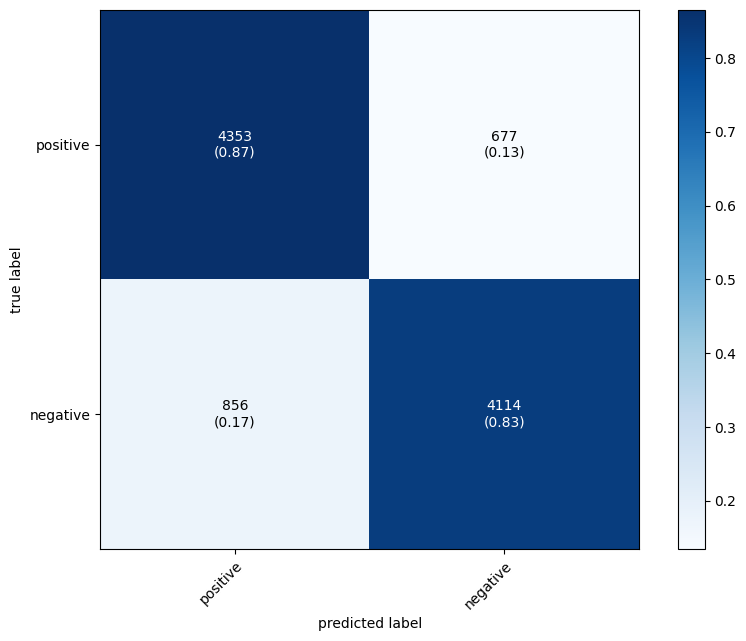

In [22]:
confusion_matrix = multiclass_confusion_matrix(
    torch.tensor(y_pred), torch.tensor(y_test), num_classes=2
)
plot_confusion_matrix(
    conf_mat=confusion_matrix.numpy(),
    class_names=["positive", "negative"],
    figsize=(10, 7),
    show_absolute=True,
    show_normed=True,
    colorbar=True,
)
plt.savefig(f"reports/raw_model_confusion_matrix_before_al.png")

# Active Learning


In [23]:
cycles = 100

In [24]:
loss_fn = nn.MSELoss()

In [25]:
def active_learning(pool_x, pool_y, method, model_estimator, num_classes, class_names):
    learner = None
    acc_train = []
    acc_test = []
    precision_result = []
    recall_result = []
    f1_result = []
    loss = []
    if method == "uncertainty_sampling":
        learner = ActiveLearner(estimator=model_estimator, query_strategy=uncertainty_sampling)
    elif method == "margin_sampling":
        learner = ActiveLearner(estimator=model_estimator, query_strategy=margin_sampling)
    elif method == "entropy_sampling":
        learner = ActiveLearner(estimator=model_estimator, query_strategy=entropy_sampling)
    elif method == "random_sampling":
        def random_sampling(Learner, pool_x, n_instances):
            n_samples = len(pool_x)
            query_idx = np.random.choice(range(n_samples), size=n_instances, replace=False)
            X_query = pool_x[query_idx]
            return query_idx, X_query

        learner = ActiveLearner(estimator=model_estimator, query_strategy=random_sampling)
    elif method == "query_by_committee":
        n_members = 3
        learner_list = list()
        for member_idx in range(n_members):
            Learner = ActiveLearner(estimator=model_estimator)
            learner_list.append(Learner)
        learner = Committee(learner_list=learner_list, query_strategy=vote_entropy_sampling)
    else:
        print("Invalid Input")
        
    print(f"Starting Active Learning with {method.replace('_', ' ')} method")

    for cycle in range(cycles):
        print(f"Cycle: {cycle + 1}")
        query_idx, _ = learner.query(pool_x, n_instances=10)
        learner.teach(X=pool_x[query_idx], y=pool_y[query_idx])
        pool_x = np.delete(pool_x, query_idx, axis=0)
        pool_y = np.delete(pool_y, query_idx, axis=0)

        model_accuracy = learner.score(x_train, y_train)
        acc_train.append(model_accuracy)
        y_pred = learner.predict(x_test)

        acc_test.append(
            multiclass_accuracy(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        precision_result.append(
            multiclass_precision(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        recall_result.append(
            multiclass_recall(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        f1_result.append(
            multiclass_f1_score(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        loss.append(
            loss_fn(
                torch.tensor(y_pred, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
            )
        )

        print(f"\tTraining Accuracy: {acc_train[-1]:.3f}")
        print(f"\tTesting Accuracy: {acc_test[-1]:.3f}")
        print(f"\tPrecision: {precision_result[-1]:.3f}")
        print(f"\tRecall: {recall_result[-1]:.3f}")
        print(f"\tF1 Score: {f1_result[-1]:.3f}")
        print(f"\tLoss: {loss[-1]:.3f}")
        
        try:
            slope = (loss[-1] - loss[-10]) / 9
            print("\tSlop after 10 Epochs", slope)
            if slope >= 0.01:
                break
        except Exception:
            continue

    print(f"Active Learning with {method} method is finished")
    confusion_matrix = multiclass_confusion_matrix(
        torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
    )
    plot_confusion_matrix(
        conf_mat=confusion_matrix.numpy(),
        class_names=class_names,
        figsize=(10, 7),
        show_absolute=True,
        show_normed=True,
        colorbar=True,
    )
    plt.savefig(f"reports/{method}_confusion_matrix_after_al.png")
    return {
        "Train Accuracy": acc_train,
        "Test Accuracy": acc_test,
        "Precision": precision_result,
        "Recall": recall_result,
        "F1 Score": f1_result,
        "Loss": loss
    }

## Random Sampling

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Starting Active Learning with random sampling method
Cycle: 1
	Training Accuracy: 0.498
	Testing Accuracy: 0.497
	Precision: 0.497
	Recall: 0.497
	F1 Score: 0.497
	Loss: 0.503
Cycle: 2
	Training Accuracy: 0.628
	Testing Accuracy: 0.632
	Precision: 0.632
	Recall: 0.632
	F1 Score: 0.632
	Loss: 0.368
Cycle: 3


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.572
	Testing Accuracy: 0.570
	Precision: 0.570
	Recall: 0.570
	F1 Score: 0.570
	Loss: 0.430
Cycle: 4
	Training Accuracy: 0.503
	Testing Accuracy: 0.501
	Precision: 0.501
	Recall: 0.501
	F1 Score: 0.501
	Loss: 0.499
Cycle: 5
	Training Accuracy: 0.506
	Testing Accuracy: 0.503
	Precision: 0.503
	Recall: 0.503
	F1 Score: 0.503
	Loss: 0.497
Cycle: 6


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.563
	Testing Accuracy: 0.560
	Precision: 0.560
	Recall: 0.560
	F1 Score: 0.560
	Loss: 0.440
Cycle: 7
	Training Accuracy: 0.585
	Testing Accuracy: 0.580
	Precision: 0.580
	Recall: 0.580
	F1 Score: 0.580
	Loss: 0.420
Cycle: 8
	Training Accuracy: 0.696
	Testing Accuracy: 0.688
	Precision: 0.688
	Recall: 0.688
	F1 Score: 0.688
	Loss: 0.312
Cycle: 9


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.727
	Testing Accuracy: 0.720
	Precision: 0.720
	Recall: 0.720
	F1 Score: 0.720
	Loss: 0.280
Cycle: 10
	Training Accuracy: 0.717
	Testing Accuracy: 0.714
	Precision: 0.714
	Recall: 0.714
	F1 Score: 0.714
	Loss: 0.286
	Slop after 10 Epochs tensor(-0.0241)
Cycle: 11
	Training Accuracy: 0.750
	Testing Accuracy: 0.747
	Precision: 0.747
	Recall: 0.747
	F1 Score: 0.747
	Loss: 0.254
	Slop after 10 Epochs tensor(-0.0127)
Cycle: 12


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.752
	Testing Accuracy: 0.748
	Precision: 0.748
	Recall: 0.748
	F1 Score: 0.748
	Loss: 0.252
	Slop after 10 Epochs tensor(-0.0198)
Cycle: 13
	Training Accuracy: 0.765
	Testing Accuracy: 0.761
	Precision: 0.761
	Recall: 0.761
	F1 Score: 0.761
	Loss: 0.239
	Slop after 10 Epochs tensor(-0.0289)
Cycle: 14
	Training Accuracy: 0.779
	Testing Accuracy: 0.776
	Precision: 0.776
	Recall: 0.776
	F1 Score: 0.776
	Loss: 0.224
	Slop after 10 Epochs tensor(-0.0303)
Cycle: 15


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.781
	Testing Accuracy: 0.775
	Precision: 0.775
	Recall: 0.775
	F1 Score: 0.775
	Loss: 0.225
	Slop after 10 Epochs tensor(-0.0239)
Cycle: 16
	Training Accuracy: 0.779
	Testing Accuracy: 0.779
	Precision: 0.779
	Recall: 0.779
	F1 Score: 0.779
	Loss: 0.221
	Slop after 10 Epochs tensor(-0.0221)
Cycle: 17
	Training Accuracy: 0.784
	Testing Accuracy: 0.779
	Precision: 0.779
	Recall: 0.779
	F1 Score: 0.779
	Loss: 0.221
	Slop after 10 Epochs tensor(-0.0101)
Cycle: 18


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.787
	Testing Accuracy: 0.782
	Precision: 0.782
	Recall: 0.782
	F1 Score: 0.782
	Loss: 0.218
	Slop after 10 Epochs tensor(-0.0069)
Cycle: 19
	Training Accuracy: 0.791
	Testing Accuracy: 0.786
	Precision: 0.786
	Recall: 0.786
	F1 Score: 0.786
	Loss: 0.214
	Slop after 10 Epochs tensor(-0.0080)
Cycle: 20
	Training Accuracy: 0.792
	Testing Accuracy: 0.786
	Precision: 0.786
	Recall: 0.786
	F1 Score: 0.786
	Loss: 0.214
	Slop after 10 Epochs tensor(-0.0044)
Cycle: 21


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.793
	Testing Accuracy: 0.787
	Precision: 0.787
	Recall: 0.787
	F1 Score: 0.787
	Loss: 0.213
	Slop after 10 Epochs tensor(-0.0043)
Cycle: 22
	Training Accuracy: 0.794
	Testing Accuracy: 0.783
	Precision: 0.783
	Recall: 0.783
	F1 Score: 0.783
	Loss: 0.217
	Slop after 10 Epochs tensor(-0.0024)
Cycle: 23
	Training Accuracy: 0.797
	Testing Accuracy: 0.789
	Precision: 0.789
	Recall: 0.789
	F1 Score: 0.789
	Loss: 0.211
	Slop after 10 Epochs tensor(-0.0014)
Cycle: 24


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.802
	Testing Accuracy: 0.792
	Precision: 0.792
	Recall: 0.792
	F1 Score: 0.792
	Loss: 0.208
	Slop after 10 Epochs tensor(-0.0019)
Cycle: 25
	Training Accuracy: 0.803
	Testing Accuracy: 0.796
	Precision: 0.796
	Recall: 0.796
	F1 Score: 0.796
	Loss: 0.204
	Slop after 10 Epochs tensor(-0.0018)
Cycle: 26
	Training Accuracy: 0.804
	Testing Accuracy: 0.795
	Precision: 0.795
	Recall: 0.795
	F1 Score: 0.795
	Loss: 0.205
	Slop after 10 Epochs tensor(-0.0018)
Cycle: 27


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.803
	Testing Accuracy: 0.797
	Precision: 0.797
	Recall: 0.797
	F1 Score: 0.797
	Loss: 0.204
	Slop after 10 Epochs tensor(-0.0016)
Cycle: 28
	Training Accuracy: 0.802
	Testing Accuracy: 0.798
	Precision: 0.798
	Recall: 0.798
	F1 Score: 0.798
	Loss: 0.202
	Slop after 10 Epochs tensor(-0.0014)
Cycle: 29
	Training Accuracy: 0.805
	Testing Accuracy: 0.800
	Precision: 0.800
	Recall: 0.800
	F1 Score: 0.800
	Loss: 0.200
	Slop after 10 Epochs tensor(-0.0015)
Cycle: 30


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.807
	Testing Accuracy: 0.802
	Precision: 0.802
	Recall: 0.802
	F1 Score: 0.802
	Loss: 0.198
	Slop after 10 Epochs tensor(-0.0017)
Cycle: 31
	Training Accuracy: 0.807
	Testing Accuracy: 0.803
	Precision: 0.803
	Recall: 0.803
	F1 Score: 0.803
	Loss: 0.197
	Slop after 10 Epochs tensor(-0.0022)
Cycle: 32


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.810
	Testing Accuracy: 0.806
	Precision: 0.806
	Recall: 0.806
	F1 Score: 0.806
	Loss: 0.194
	Slop after 10 Epochs tensor(-0.0019)
Cycle: 33
	Training Accuracy: 0.816
	Testing Accuracy: 0.812
	Precision: 0.812
	Recall: 0.812
	F1 Score: 0.812
	Loss: 0.188
	Slop after 10 Epochs tensor(-0.0022)
Cycle: 34
	Training Accuracy: 0.813
	Testing Accuracy: 0.809
	Precision: 0.809
	Recall: 0.809
	F1 Score: 0.809
	Loss: 0.191
	Slop after 10 Epochs tensor(-0.0014)
Cycle: 35


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.814
	Testing Accuracy: 0.809
	Precision: 0.809
	Recall: 0.809
	F1 Score: 0.809
	Loss: 0.191
	Slop after 10 Epochs tensor(-0.0016)
Cycle: 36
	Training Accuracy: 0.813
	Testing Accuracy: 0.809
	Precision: 0.809
	Recall: 0.809
	F1 Score: 0.809
	Loss: 0.191
	Slop after 10 Epochs tensor(-0.0014)
Cycle: 37
	Training Accuracy: 0.814
	Testing Accuracy: 0.810
	Precision: 0.810
	Recall: 0.810
	F1 Score: 0.810
	Loss: 0.190
	Slop after 10 Epochs tensor(-0.0013)
Cycle: 38


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.815
	Testing Accuracy: 0.812
	Precision: 0.812
	Recall: 0.812
	F1 Score: 0.812
	Loss: 0.189
	Slop after 10 Epochs tensor(-0.0013)
Cycle: 39
	Training Accuracy: 0.814
	Testing Accuracy: 0.811
	Precision: 0.811
	Recall: 0.811
	F1 Score: 0.811
	Loss: 0.189
	Slop after 10 Epochs tensor(-0.0010)
Cycle: 40
	Training Accuracy: 0.815
	Testing Accuracy: 0.814
	Precision: 0.814
	Recall: 0.814
	F1 Score: 0.814
	Loss: 0.186
	Slop after 10 Epochs tensor(-0.0012)
Cycle: 41


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.819
	Testing Accuracy: 0.816
	Precision: 0.816
	Recall: 0.816
	F1 Score: 0.816
	Loss: 0.184
	Slop after 10 Epochs tensor(-0.0012)
Cycle: 42
	Training Accuracy: 0.820
	Testing Accuracy: 0.816
	Precision: 0.816
	Recall: 0.816
	F1 Score: 0.816
	Loss: 0.184
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 43
	Training Accuracy: 0.819
	Testing Accuracy: 0.818
	Precision: 0.818
	Recall: 0.818
	F1 Score: 0.818
	Loss: 0.182
	Slop after 10 Epochs tensor(-0.0011)
Cycle: 44


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.821
	Testing Accuracy: 0.819
	Precision: 0.819
	Recall: 0.819
	F1 Score: 0.819
	Loss: 0.181
	Slop after 10 Epochs tensor(-0.0011)
Cycle: 45
	Training Accuracy: 0.823
	Testing Accuracy: 0.820
	Precision: 0.820
	Recall: 0.820
	F1 Score: 0.820
	Loss: 0.180
	Slop after 10 Epochs tensor(-0.0012)
Cycle: 46
	Training Accuracy: 0.826
	Testing Accuracy: 0.821
	Precision: 0.821
	Recall: 0.821
	F1 Score: 0.821
	Loss: 0.179
	Slop after 10 Epochs tensor(-0.0012)
Cycle: 47


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.825
	Testing Accuracy: 0.821
	Precision: 0.821
	Recall: 0.821
	F1 Score: 0.821
	Loss: 0.179
	Slop after 10 Epochs tensor(-0.0011)
Cycle: 48
	Training Accuracy: 0.825
	Testing Accuracy: 0.821
	Precision: 0.821
	Recall: 0.821
	F1 Score: 0.821
	Loss: 0.179
	Slop after 10 Epochs tensor(-0.0011)
Cycle: 49
	Training Accuracy: 0.826
	Testing Accuracy: 0.824
	Precision: 0.824
	Recall: 0.824
	F1 Score: 0.824
	Loss: 0.176
	Slop after 10 Epochs tensor(-0.0011)
Cycle: 50


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.829
	Testing Accuracy: 0.823
	Precision: 0.823
	Recall: 0.823
	F1 Score: 0.823
	Loss: 0.177
	Slop after 10 Epochs tensor(-0.0008)
Cycle: 51
	Training Accuracy: 0.829
	Testing Accuracy: 0.825
	Precision: 0.825
	Recall: 0.825
	F1 Score: 0.825
	Loss: 0.175
	Slop after 10 Epochs tensor(-0.0009)
Cycle: 52
	Training Accuracy: 0.830
	Testing Accuracy: 0.823
	Precision: 0.823
	Recall: 0.823
	F1 Score: 0.823
	Loss: 0.176
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 53


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.830
	Testing Accuracy: 0.827
	Precision: 0.827
	Recall: 0.827
	F1 Score: 0.827
	Loss: 0.173
	Slop after 10 Epochs tensor(-0.0008)
Cycle: 54
	Training Accuracy: 0.828
	Testing Accuracy: 0.827
	Precision: 0.827
	Recall: 0.827
	F1 Score: 0.827
	Loss: 0.173
	Slop after 10 Epochs tensor(-0.0008)
Cycle: 55
	Training Accuracy: 0.831
	Testing Accuracy: 0.827
	Precision: 0.827
	Recall: 0.827
	F1 Score: 0.827
	Loss: 0.173
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 56


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.830
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 0.171
	Slop after 10 Epochs tensor(-0.0008)
Cycle: 57
	Training Accuracy: 0.832
	Testing Accuracy: 0.828
	Precision: 0.828
	Recall: 0.828
	F1 Score: 0.828
	Loss: 0.172
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 58
	Training Accuracy: 0.832
	Testing Accuracy: 0.827
	Precision: 0.827
	Recall: 0.827
	F1 Score: 0.827
	Loss: 0.173
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 59


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.832
	Testing Accuracy: 0.828
	Precision: 0.828
	Recall: 0.828
	F1 Score: 0.828
	Loss: 0.172
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 60
	Training Accuracy: 0.832
	Testing Accuracy: 0.827
	Precision: 0.827
	Recall: 0.827
	F1 Score: 0.827
	Loss: 0.173
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 61


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.832
	Testing Accuracy: 0.827
	Precision: 0.827
	Recall: 0.827
	F1 Score: 0.827
	Loss: 0.173
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 62
	Training Accuracy: 0.834
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 0.171
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 63
	Training Accuracy: 0.832
	Testing Accuracy: 0.828
	Precision: 0.828
	Recall: 0.828
	F1 Score: 0.828
	Loss: 0.172
	Slop after 10 Epochs tensor(-0.0001)
Cycle: 64


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.835
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 0.171
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 65
	Training Accuracy: 0.835
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 66
	Training Accuracy: 0.836
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 67


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.836
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 68
	Training Accuracy: 0.836
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 69


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.838
	Testing Accuracy: 0.832
	Precision: 0.832
	Recall: 0.832
	F1 Score: 0.832
	Loss: 0.168
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 70
	Training Accuracy: 0.838
	Testing Accuracy: 0.833
	Precision: 0.833
	Recall: 0.833
	F1 Score: 0.833
	Loss: 0.167
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 71
	Training Accuracy: 0.839
	Testing Accuracy: 0.832
	Precision: 0.832
	Recall: 0.832
	F1 Score: 0.832
	Loss: 0.168
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 72


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.838
	Testing Accuracy: 0.832
	Precision: 0.832
	Recall: 0.832
	F1 Score: 0.832
	Loss: 0.168
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 73
	Training Accuracy: 0.839
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 74


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.837
	Testing Accuracy: 0.830
	Precision: 0.830
	Recall: 0.830
	F1 Score: 0.830
	Loss: 0.170
	Slop after 10 Epochs tensor(3.3332e-05)
Cycle: 75
	Training Accuracy: 0.837
	Testing Accuracy: 0.830
	Precision: 0.830
	Recall: 0.830
	F1 Score: 0.830
	Loss: 0.170
	Slop after 10 Epochs tensor(3.3332e-05)
Cycle: 76
	Training Accuracy: 0.837
	Testing Accuracy: 0.832
	Precision: 0.832
	Recall: 0.832
	F1 Score: 0.832
	Loss: 0.168
	Slop after 10 Epochs tensor(-7.7777e-05)
Cycle: 77


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.838
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(-3.3334e-05)
Cycle: 78
	Training Accuracy: 0.839
	Testing Accuracy: 0.832
	Precision: 0.832
	Recall: 0.832
	F1 Score: 0.832
	Loss: 0.168
	Slop after 10 Epochs tensor(-5.5556e-05)
Cycle: 79
	Training Accuracy: 0.839
	Testing Accuracy: 0.832
	Precision: 0.832
	Recall: 0.832
	F1 Score: 0.832
	Loss: 0.168
	Slop after 10 Epochs tensor(0.0001)
Cycle: 80


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.839
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(0.0001)
Cycle: 81
	Training Accuracy: 0.839
	Testing Accuracy: 0.832
	Precision: 0.832
	Recall: 0.832
	F1 Score: 0.832
	Loss: 0.168
	Slop after 10 Epochs tensor(-5.5556e-05)
Cycle: 82
	Training Accuracy: 0.839
	Testing Accuracy: 0.834
	Precision: 0.834
	Recall: 0.834
	F1 Score: 0.834
	Loss: 0.166
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 83


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.840
	Testing Accuracy: 0.834
	Precision: 0.834
	Recall: 0.834
	F1 Score: 0.834
	Loss: 0.166
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 84
	Training Accuracy: 0.839
	Testing Accuracy: 0.834
	Precision: 0.834
	Recall: 0.834
	F1 Score: 0.834
	Loss: 0.166
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 85
	Training Accuracy: 0.839
	Testing Accuracy: 0.833
	Precision: 0.833
	Recall: 0.833
	F1 Score: 0.833
	Loss: 0.167
	Slop after 10 Epochs tensor(-0.0001)
Cycle: 86


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.840
	Testing Accuracy: 0.835
	Precision: 0.835
	Recall: 0.835
	F1 Score: 0.835
	Loss: 0.166
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 87
	Training Accuracy: 0.840
	Testing Accuracy: 0.834
	Precision: 0.834
	Recall: 0.834
	F1 Score: 0.834
	Loss: 0.166
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 88
	Training Accuracy: 0.841
	Testing Accuracy: 0.834
	Precision: 0.834
	Recall: 0.834
	F1 Score: 0.834
	Loss: 0.166
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 89


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.840
	Testing Accuracy: 0.834
	Precision: 0.834
	Recall: 0.834
	F1 Score: 0.834
	Loss: 0.166
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 90
	Training Accuracy: 0.842
	Testing Accuracy: 0.834
	Precision: 0.834
	Recall: 0.834
	F1 Score: 0.834
	Loss: 0.166
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 91
	Training Accuracy: 0.844
	Testing Accuracy: 0.835
	Precision: 0.835
	Recall: 0.835
	F1 Score: 0.835
	Loss: 0.165
	Slop after 10 Epochs tensor(-0.0001)
Cycle: 92


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.843
	Testing Accuracy: 0.835
	Precision: 0.835
	Recall: 0.835
	F1 Score: 0.835
	Loss: 0.166
	Slop after 10 Epochs tensor(-3.3334e-05)
Cycle: 93
	Training Accuracy: 0.843
	Testing Accuracy: 0.835
	Precision: 0.835
	Recall: 0.835
	F1 Score: 0.835
	Loss: 0.165
	Slop after 10 Epochs tensor(-4.4445e-05)
Cycle: 94
	Training Accuracy: 0.844
	Testing Accuracy: 0.835
	Precision: 0.835
	Recall: 0.835
	F1 Score: 0.835
	Loss: 0.165
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 95


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.844
	Testing Accuracy: 0.835
	Precision: 0.835
	Recall: 0.835
	F1 Score: 0.835
	Loss: 0.165
	Slop after 10 Epochs tensor(-5.5555e-05)
Cycle: 96
	Training Accuracy: 0.844
	Testing Accuracy: 0.835
	Precision: 0.835
	Recall: 0.835
	F1 Score: 0.835
	Loss: 0.166
	Slop after 10 Epochs tensor(-3.3334e-05)
Cycle: 97


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.843
	Testing Accuracy: 0.835
	Precision: 0.835
	Recall: 0.835
	F1 Score: 0.835
	Loss: 0.165
	Slop after 10 Epochs tensor(-5.5556e-05)
Cycle: 98
	Training Accuracy: 0.844
	Testing Accuracy: 0.836
	Precision: 0.836
	Recall: 0.836
	F1 Score: 0.836
	Loss: 0.164
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 99
	Training Accuracy: 0.844
	Testing Accuracy: 0.836
	Precision: 0.836
	Recall: 0.836
	F1 Score: 0.836
	Loss: 0.164
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 100


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.843
	Testing Accuracy: 0.837
	Precision: 0.837
	Recall: 0.837
	F1 Score: 0.837
	Loss: 0.163
	Slop after 10 Epochs tensor(-0.0002)
Active Learning with random_sampling method is finished


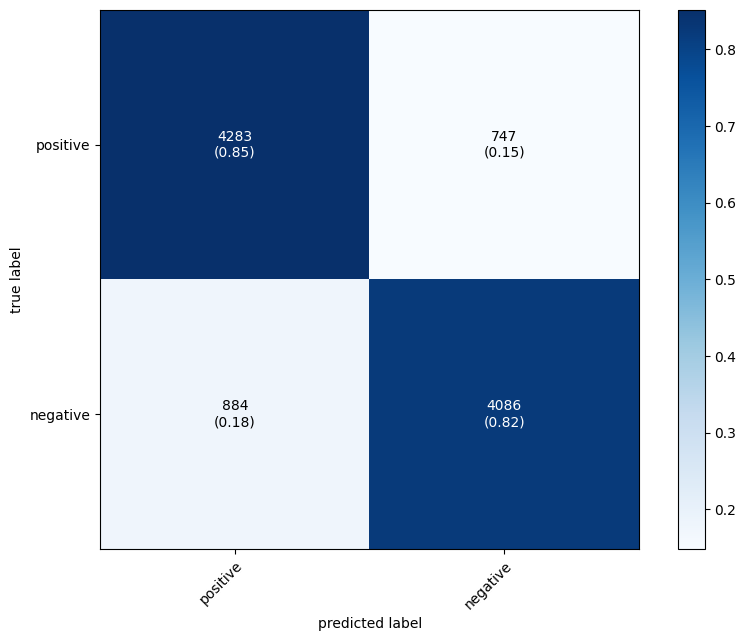

In [26]:
results_random_sampling = active_learning(x_pool, y_pool, "random_sampling", clf, 2, ["positive", "negative"])

## Uncertainty Sampling

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Starting Active Learning with uncertainty sampling method
Cycle: 1
	Training Accuracy: 0.502
	Testing Accuracy: 0.503
	Precision: 0.503
	Recall: 0.503
	F1 Score: 0.503
	Loss: 0.497
Cycle: 2
	Training Accuracy: 0.511
	Testing Accuracy: 0.509
	Precision: 0.509
	Recall: 0.509
	F1 Score: 0.509
	Loss: 0.491
Cycle: 3


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.574
	Testing Accuracy: 0.569
	Precision: 0.569
	Recall: 0.569
	F1 Score: 0.569
	Loss: 0.431
Cycle: 4
	Training Accuracy: 0.640
	Testing Accuracy: 0.632
	Precision: 0.632
	Recall: 0.632
	F1 Score: 0.632
	Loss: 0.368
Cycle: 5
	Training Accuracy: 0.672
	Testing Accuracy: 0.660
	Precision: 0.660
	Recall: 0.660
	F1 Score: 0.660
	Loss: 0.340
Cycle: 6


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.709
	Testing Accuracy: 0.703
	Precision: 0.703
	Recall: 0.703
	F1 Score: 0.703
	Loss: 0.297
Cycle: 7
	Training Accuracy: 0.731
	Testing Accuracy: 0.725
	Precision: 0.725
	Recall: 0.725
	F1 Score: 0.725
	Loss: 0.275
Cycle: 8
	Training Accuracy: 0.752
	Testing Accuracy: 0.751
	Precision: 0.751
	Recall: 0.751
	F1 Score: 0.751
	Loss: 0.249
Cycle: 9
	Training Accuracy: 0.756
	Testing Accuracy: 0.760
	Precision: 0.760
	Recall: 0.760
	F1 Score: 0.760
	Loss: 0.240
Cycle: 10


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.768
	Testing Accuracy: 0.765
	Precision: 0.765
	Recall: 0.765
	F1 Score: 0.765
	Loss: 0.235
	Slop after 10 Epochs tensor(-0.0292)
Cycle: 11
	Training Accuracy: 0.761
	Testing Accuracy: 0.753
	Precision: 0.753
	Recall: 0.753
	F1 Score: 0.753
	Loss: 0.247
	Slop after 10 Epochs tensor(-0.0271)
Cycle: 12
	Training Accuracy: 0.758
	Testing Accuracy: 0.752
	Precision: 0.752
	Recall: 0.752
	F1 Score: 0.752
	Loss: 0.248
	Slop after 10 Epochs tensor(-0.0203)
Cycle: 13
	Training Accuracy: 0.775
	Testing Accuracy: 0.771
	Precision: 0.771
	Recall: 0.771
	F1 Score: 0.771
	Loss: 0.229
	Slop after 10 Epochs tensor(-0.0154)
Cycle: 14


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.796
	Testing Accuracy: 0.791
	Precision: 0.791
	Recall: 0.791
	F1 Score: 0.791
	Loss: 0.209
	Slop after 10 Epochs tensor(-0.0145)
Cycle: 15
	Training Accuracy: 0.796
	Testing Accuracy: 0.787
	Precision: 0.787
	Recall: 0.787
	F1 Score: 0.787
	Loss: 0.213
	Slop after 10 Epochs tensor(-0.0093)
Cycle: 16
	Training Accuracy: 0.802
	Testing Accuracy: 0.793
	Precision: 0.793
	Recall: 0.793
	F1 Score: 0.793
	Loss: 0.207
	Slop after 10 Epochs tensor(-0.0075)
Cycle: 17


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.804
	Testing Accuracy: 0.794
	Precision: 0.794
	Recall: 0.794
	F1 Score: 0.794
	Loss: 0.206
	Slop after 10 Epochs tensor(-0.0048)
Cycle: 18
	Training Accuracy: 0.798
	Testing Accuracy: 0.789
	Precision: 0.789
	Recall: 0.789
	F1 Score: 0.789
	Loss: 0.211
	Slop after 10 Epochs tensor(-0.0032)
Cycle: 19
	Training Accuracy: 0.806
	Testing Accuracy: 0.794
	Precision: 0.794
	Recall: 0.794
	F1 Score: 0.794
	Loss: 0.206
	Slop after 10 Epochs tensor(-0.0032)
Cycle: 20


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.807
	Testing Accuracy: 0.791
	Precision: 0.791
	Recall: 0.791
	F1 Score: 0.791
	Loss: 0.209
	Slop after 10 Epochs tensor(-0.0042)
Cycle: 21
	Training Accuracy: 0.811
	Testing Accuracy: 0.796
	Precision: 0.796
	Recall: 0.796
	F1 Score: 0.796
	Loss: 0.204
	Slop after 10 Epochs tensor(-0.0049)
Cycle: 22
	Training Accuracy: 0.819
	Testing Accuracy: 0.803
	Precision: 0.803
	Recall: 0.803
	F1 Score: 0.803
	Loss: 0.197
	Slop after 10 Epochs tensor(-0.0035)
Cycle: 23
	Training Accuracy: 0.816
	Testing Accuracy: 0.801
	Precision: 0.801
	Recall: 0.801
	F1 Score: 0.801
	Loss: 0.199
	Slop after 10 Epochs tensor(-0.0011)
Cycle: 24


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.819
	Testing Accuracy: 0.803
	Precision: 0.803
	Recall: 0.803
	F1 Score: 0.803
	Loss: 0.197
	Slop after 10 Epochs tensor(-0.0018)
Cycle: 25
	Training Accuracy: 0.822
	Testing Accuracy: 0.807
	Precision: 0.807
	Recall: 0.807
	F1 Score: 0.807
	Loss: 0.193
	Slop after 10 Epochs tensor(-0.0016)
Cycle: 26
	Training Accuracy: 0.826
	Testing Accuracy: 0.812
	Precision: 0.812
	Recall: 0.812
	F1 Score: 0.812
	Loss: 0.188
	Slop after 10 Epochs tensor(-0.0019)
Cycle: 27


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.826
	Testing Accuracy: 0.810
	Precision: 0.810
	Recall: 0.810
	F1 Score: 0.810
	Loss: 0.190
	Slop after 10 Epochs tensor(-0.0024)
Cycle: 28
	Training Accuracy: 0.826
	Testing Accuracy: 0.809
	Precision: 0.809
	Recall: 0.809
	F1 Score: 0.809
	Loss: 0.191
	Slop after 10 Epochs tensor(-0.0017)
Cycle: 29
	Training Accuracy: 0.833
	Testing Accuracy: 0.810
	Precision: 0.810
	Recall: 0.810
	F1 Score: 0.810
	Loss: 0.190
	Slop after 10 Epochs tensor(-0.0022)
Cycle: 30


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.832
	Testing Accuracy: 0.813
	Precision: 0.813
	Recall: 0.813
	F1 Score: 0.813
	Loss: 0.187
	Slop after 10 Epochs tensor(-0.0019)
Cycle: 31
	Training Accuracy: 0.832
	Testing Accuracy: 0.816
	Precision: 0.816
	Recall: 0.816
	F1 Score: 0.816
	Loss: 0.184
	Slop after 10 Epochs tensor(-0.0014)
Cycle: 32
	Training Accuracy: 0.830
	Testing Accuracy: 0.815
	Precision: 0.815
	Recall: 0.815
	F1 Score: 0.815
	Loss: 0.185
	Slop after 10 Epochs tensor(-0.0015)
Cycle: 33


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.831
	Testing Accuracy: 0.817
	Precision: 0.817
	Recall: 0.817
	F1 Score: 0.817
	Loss: 0.183
	Slop after 10 Epochs tensor(-0.0016)
Cycle: 34
	Training Accuracy: 0.832
	Testing Accuracy: 0.819
	Precision: 0.819
	Recall: 0.819
	F1 Score: 0.819
	Loss: 0.181
	Slop after 10 Epochs tensor(-0.0013)
Cycle: 35
	Training Accuracy: 0.835
	Testing Accuracy: 0.820
	Precision: 0.820
	Recall: 0.820
	F1 Score: 0.820
	Loss: 0.180
	Slop after 10 Epochs tensor(-0.0009)
Cycle: 36


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.841
	Testing Accuracy: 0.826
	Precision: 0.826
	Recall: 0.826
	F1 Score: 0.826
	Loss: 0.174
	Slop after 10 Epochs tensor(-0.0018)
Cycle: 37
	Training Accuracy: 0.842
	Testing Accuracy: 0.824
	Precision: 0.824
	Recall: 0.824
	F1 Score: 0.824
	Loss: 0.176
	Slop after 10 Epochs tensor(-0.0016)
Cycle: 38


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.842
	Testing Accuracy: 0.830
	Precision: 0.830
	Recall: 0.830
	F1 Score: 0.830
	Loss: 0.170
	Slop after 10 Epochs tensor(-0.0022)
Cycle: 39
	Training Accuracy: 0.843
	Testing Accuracy: 0.827
	Precision: 0.827
	Recall: 0.827
	F1 Score: 0.827
	Loss: 0.173
	Slop after 10 Epochs tensor(-0.0015)
Cycle: 40
	Training Accuracy: 0.844
	Testing Accuracy: 0.828
	Precision: 0.828
	Recall: 0.828
	F1 Score: 0.828
	Loss: 0.172
	Slop after 10 Epochs tensor(-0.0014)
Cycle: 41


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.845
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(-0.0018)
Cycle: 42
	Training Accuracy: 0.845
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(-0.0015)
Cycle: 43
	Training Accuracy: 0.843
	Testing Accuracy: 0.828
	Precision: 0.828
	Recall: 0.828
	F1 Score: 0.828
	Loss: 0.172
	Slop after 10 Epochs tensor(-0.0010)
Cycle: 44


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.844
	Testing Accuracy: 0.830
	Precision: 0.830
	Recall: 0.830
	F1 Score: 0.830
	Loss: 0.170
	Slop after 10 Epochs tensor(-0.0011)
Cycle: 45
	Training Accuracy: 0.842
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 0.171
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 46
	Training Accuracy: 0.841
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(-0.0008)
Cycle: 47


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.843
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 48
	Training Accuracy: 0.844
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 0.171
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 49
	Training Accuracy: 0.846
	Testing Accuracy: 0.830
	Precision: 0.830
	Recall: 0.830
	F1 Score: 0.830
	Loss: 0.170
	Slop after 10 Epochs tensor(-0.0001)
Cycle: 50


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.846
	Testing Accuracy: 0.830
	Precision: 0.830
	Recall: 0.830
	F1 Score: 0.830
	Loss: 0.170
	Slop after 10 Epochs tensor(0.0001)
Cycle: 51
	Training Accuracy: 0.846
	Testing Accuracy: 0.833
	Precision: 0.833
	Recall: 0.833
	F1 Score: 0.833
	Loss: 0.167
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 52
	Training Accuracy: 0.850
	Testing Accuracy: 0.833
	Precision: 0.833
	Recall: 0.833
	F1 Score: 0.833
	Loss: 0.167
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 53


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.851
	Testing Accuracy: 0.837
	Precision: 0.837
	Recall: 0.837
	F1 Score: 0.837
	Loss: 0.163
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 54
	Training Accuracy: 0.849
	Testing Accuracy: 0.837
	Precision: 0.837
	Recall: 0.837
	F1 Score: 0.837
	Loss: 0.163
	Slop after 10 Epochs tensor(-0.0008)
Cycle: 55
	Training Accuracy: 0.850
	Testing Accuracy: 0.836
	Precision: 0.836
	Recall: 0.836
	F1 Score: 0.836
	Loss: 0.164
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 56


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.851
	Testing Accuracy: 0.835
	Precision: 0.835
	Recall: 0.835
	F1 Score: 0.835
	Loss: 0.165
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 57
	Training Accuracy: 0.851
	Testing Accuracy: 0.837
	Precision: 0.837
	Recall: 0.837
	F1 Score: 0.837
	Loss: 0.163
	Slop after 10 Epochs tensor(-0.0009)
Cycle: 58
	Training Accuracy: 0.852
	Testing Accuracy: 0.835
	Precision: 0.835
	Recall: 0.835
	F1 Score: 0.835
	Loss: 0.166
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 59


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.851
	Testing Accuracy: 0.835
	Precision: 0.835
	Recall: 0.835
	F1 Score: 0.835
	Loss: 0.165
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 60
	Training Accuracy: 0.855
	Testing Accuracy: 0.837
	Precision: 0.837
	Recall: 0.837
	F1 Score: 0.837
	Loss: 0.163
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 61
	Training Accuracy: 0.855
	Testing Accuracy: 0.837
	Precision: 0.837
	Recall: 0.837
	F1 Score: 0.837
	Loss: 0.163
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 62


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.853
	Testing Accuracy: 0.836
	Precision: 0.836
	Recall: 0.836
	F1 Score: 0.836
	Loss: 0.164
	Slop after 10 Epochs tensor(2.2223e-05)
Cycle: 63
	Training Accuracy: 0.855
	Testing Accuracy: 0.835
	Precision: 0.835
	Recall: 0.835
	F1 Score: 0.835
	Loss: 0.165
	Slop after 10 Epochs tensor(0.0002)
Cycle: 64
	Training Accuracy: 0.853
	Testing Accuracy: 0.837
	Precision: 0.837
	Recall: 0.837
	F1 Score: 0.837
	Loss: 0.163
	Slop after 10 Epochs tensor(-0.0001)
Cycle: 65


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.855
	Testing Accuracy: 0.836
	Precision: 0.836
	Recall: 0.836
	F1 Score: 0.836
	Loss: 0.164
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 66
	Training Accuracy: 0.855
	Testing Accuracy: 0.837
	Precision: 0.837
	Recall: 0.837
	F1 Score: 0.837
	Loss: 0.163
	Slop after 10 Epochs tensor(-4.4445e-05)
Cycle: 67
	Training Accuracy: 0.856
	Testing Accuracy: 0.838
	Precision: 0.838
	Recall: 0.838
	F1 Score: 0.838
	Loss: 0.162
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 68


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.854
	Testing Accuracy: 0.836
	Precision: 0.836
	Recall: 0.836
	F1 Score: 0.836
	Loss: 0.164
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 69
	Training Accuracy: 0.858
	Testing Accuracy: 0.839
	Precision: 0.839
	Recall: 0.839
	F1 Score: 0.839
	Loss: 0.161
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 70


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.858
	Testing Accuracy: 0.839
	Precision: 0.839
	Recall: 0.839
	F1 Score: 0.839
	Loss: 0.161
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 71
	Training Accuracy: 0.857
	Testing Accuracy: 0.840
	Precision: 0.840
	Recall: 0.840
	F1 Score: 0.840
	Loss: 0.160
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 72
	Training Accuracy: 0.857
	Testing Accuracy: 0.839
	Precision: 0.839
	Recall: 0.839
	F1 Score: 0.839
	Loss: 0.161
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 73


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.859
	Testing Accuracy: 0.842
	Precision: 0.842
	Recall: 0.842
	F1 Score: 0.842
	Loss: 0.158
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 74
	Training Accuracy: 0.859
	Testing Accuracy: 0.842
	Precision: 0.842
	Recall: 0.842
	F1 Score: 0.842
	Loss: 0.158
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 75
	Training Accuracy: 0.858
	Testing Accuracy: 0.839
	Precision: 0.839
	Recall: 0.839
	F1 Score: 0.839
	Loss: 0.161
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 76


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.858
	Testing Accuracy: 0.840
	Precision: 0.840
	Recall: 0.840
	F1 Score: 0.840
	Loss: 0.160
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 77
	Training Accuracy: 0.858
	Testing Accuracy: 0.840
	Precision: 0.840
	Recall: 0.840
	F1 Score: 0.840
	Loss: 0.160
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 78
	Training Accuracy: 0.859
	Testing Accuracy: 0.840
	Precision: 0.840
	Recall: 0.840
	F1 Score: 0.840
	Loss: 0.161
	Slop after 10 Epochs tensor(-4.4444e-05)
Cycle: 79


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.861
	Testing Accuracy: 0.841
	Precision: 0.841
	Recall: 0.841
	F1 Score: 0.841
	Loss: 0.159
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 80
	Training Accuracy: 0.862
	Testing Accuracy: 0.841
	Precision: 0.841
	Recall: 0.841
	F1 Score: 0.841
	Loss: 0.159
	Slop after 10 Epochs tensor(-3.3334e-05)
Cycle: 81


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.862
	Testing Accuracy: 0.840
	Precision: 0.840
	Recall: 0.840
	F1 Score: 0.840
	Loss: 0.160
	Slop after 10 Epochs tensor(-0.0001)
Cycle: 82
	Training Accuracy: 0.860
	Testing Accuracy: 0.839
	Precision: 0.839
	Recall: 0.839
	F1 Score: 0.839
	Loss: 0.161
	Slop after 10 Epochs tensor(0.0004)
Cycle: 83
	Training Accuracy: 0.861
	Testing Accuracy: 0.838
	Precision: 0.838
	Recall: 0.838
	F1 Score: 0.838
	Loss: 0.162
	Slop after 10 Epochs tensor(0.0004)
Cycle: 84


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.863
	Testing Accuracy: 0.838
	Precision: 0.838
	Recall: 0.838
	F1 Score: 0.838
	Loss: 0.162
	Slop after 10 Epochs tensor(0.0001)
Cycle: 85
	Training Accuracy: 0.862
	Testing Accuracy: 0.839
	Precision: 0.839
	Recall: 0.839
	F1 Score: 0.839
	Loss: 0.161
	Slop after 10 Epochs tensor(0.0001)
Cycle: 86
	Training Accuracy: 0.862
	Testing Accuracy: 0.837
	Precision: 0.837
	Recall: 0.837
	F1 Score: 0.837
	Loss: 0.163
	Slop after 10 Epochs tensor(0.0003)
Cycle: 87


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.860
	Testing Accuracy: 0.838
	Precision: 0.838
	Recall: 0.838
	F1 Score: 0.838
	Loss: 0.162
	Slop after 10 Epochs tensor(0.0002)
Cycle: 88
	Training Accuracy: 0.860
	Testing Accuracy: 0.840
	Precision: 0.840
	Recall: 0.840
	F1 Score: 0.840
	Loss: 0.160
	Slop after 10 Epochs tensor(0.0001)
Cycle: 89


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.860
	Testing Accuracy: 0.839
	Precision: 0.839
	Recall: 0.839
	F1 Score: 0.839
	Loss: 0.162
	Slop after 10 Epochs tensor(0.0003)
Cycle: 90
	Training Accuracy: 0.859
	Testing Accuracy: 0.839
	Precision: 0.839
	Recall: 0.839
	F1 Score: 0.839
	Loss: 0.161
	Slop after 10 Epochs tensor(0.0001)
Cycle: 91


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.861
	Testing Accuracy: 0.838
	Precision: 0.838
	Recall: 0.838
	F1 Score: 0.838
	Loss: 0.162
	Slop after 10 Epochs tensor(7.7777e-05)
Cycle: 92
	Training Accuracy: 0.862
	Testing Accuracy: 0.840
	Precision: 0.840
	Recall: 0.840
	F1 Score: 0.840
	Loss: 0.161
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 93
	Training Accuracy: 0.862
	Testing Accuracy: 0.840
	Precision: 0.840
	Recall: 0.840
	F1 Score: 0.840
	Loss: 0.160
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 94


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.863
	Testing Accuracy: 0.840
	Precision: 0.840
	Recall: 0.840
	F1 Score: 0.840
	Loss: 0.160
	Slop after 10 Epochs tensor(-0.0001)
Cycle: 95
	Training Accuracy: 0.863
	Testing Accuracy: 0.842
	Precision: 0.842
	Recall: 0.842
	F1 Score: 0.842
	Loss: 0.158
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 96
	Training Accuracy: 0.863
	Testing Accuracy: 0.842
	Precision: 0.842
	Recall: 0.842
	F1 Score: 0.842
	Loss: 0.158
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 97


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.864
	Testing Accuracy: 0.841
	Precision: 0.841
	Recall: 0.841
	F1 Score: 0.841
	Loss: 0.159
	Slop after 10 Epochs tensor(-0.0001)
Cycle: 98
	Training Accuracy: 0.864
	Testing Accuracy: 0.843
	Precision: 0.843
	Recall: 0.843
	F1 Score: 0.843
	Loss: 0.157
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 99


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.866
	Testing Accuracy: 0.843
	Precision: 0.843
	Recall: 0.843
	F1 Score: 0.843
	Loss: 0.157
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 100
	Training Accuracy: 0.867
	Testing Accuracy: 0.843
	Precision: 0.843
	Recall: 0.843
	F1 Score: 0.843
	Loss: 0.157
	Slop after 10 Epochs tensor(-0.0005)
Active Learning with uncertainty_sampling method is finished


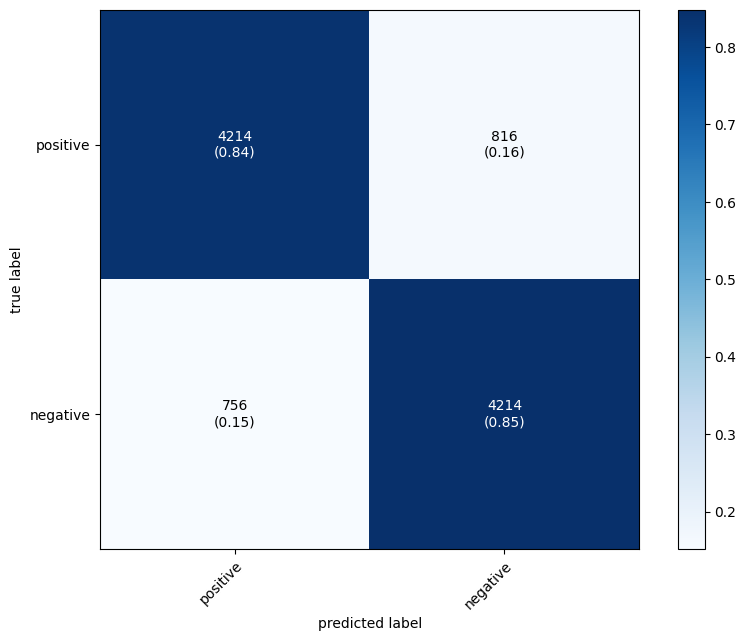

In [27]:
results_uncertainty_sampling = active_learning(x_pool, y_pool, "uncertainty_sampling", clf, 2, ["positive", "negative"])

## Margin Sampling

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Starting Active Learning with margin sampling method
Cycle: 1
	Training Accuracy: 0.528
	Testing Accuracy: 0.541
	Precision: 0.541
	Recall: 0.541
	F1 Score: 0.541
	Loss: 0.458
Cycle: 2
	Training Accuracy: 0.609
	Testing Accuracy: 0.618
	Precision: 0.618
	Recall: 0.618
	F1 Score: 0.618
	Loss: 0.382
Cycle: 3
	Training Accuracy: 0.521
	Testing Accuracy: 0.522
	Precision: 0.522
	Recall: 0.522
	F1 Score: 0.522
	Loss: 0.478
Cycle: 4


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.610
	Testing Accuracy: 0.615
	Precision: 0.615
	Recall: 0.615
	F1 Score: 0.615
	Loss: 0.385
Cycle: 5
	Training Accuracy: 0.695
	Testing Accuracy: 0.695
	Precision: 0.695
	Recall: 0.695
	F1 Score: 0.695
	Loss: 0.305
Cycle: 6
	Training Accuracy: 0.724
	Testing Accuracy: 0.725
	Precision: 0.725
	Recall: 0.725
	F1 Score: 0.726
	Loss: 0.275
Cycle: 7
	Training Accuracy: 0.727
	Testing Accuracy: 0.726
	Precision: 0.726
	Recall: 0.726
	F1 Score: 0.726
	Loss: 0.274
Cycle: 8


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.762
	Testing Accuracy: 0.760
	Precision: 0.760
	Recall: 0.760
	F1 Score: 0.760
	Loss: 0.241
Cycle: 9
	Training Accuracy: 0.791
	Testing Accuracy: 0.781
	Precision: 0.781
	Recall: 0.781
	F1 Score: 0.781
	Loss: 0.219
Cycle: 10
	Training Accuracy: 0.789
	Testing Accuracy: 0.775
	Precision: 0.775
	Recall: 0.775
	F1 Score: 0.775
	Loss: 0.225
	Slop after 10 Epochs tensor(-0.0260)
Cycle: 11
	Training Accuracy: 0.800
	Testing Accuracy: 0.788
	Precision: 0.788
	Recall: 0.788
	F1 Score: 0.788
	Loss: 0.212
	Slop after 10 Epochs tensor(-0.0189)
Cycle: 12


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.795
	Testing Accuracy: 0.789
	Precision: 0.789
	Recall: 0.789
	F1 Score: 0.789
	Loss: 0.211
	Slop after 10 Epochs tensor(-0.0297)
Cycle: 13
	Training Accuracy: 0.783
	Testing Accuracy: 0.779
	Precision: 0.779
	Recall: 0.779
	F1 Score: 0.779
	Loss: 0.221
	Slop after 10 Epochs tensor(-0.0182)
Cycle: 14
	Training Accuracy: 0.790
	Testing Accuracy: 0.781
	Precision: 0.781
	Recall: 0.781
	F1 Score: 0.781
	Loss: 0.219
	Slop after 10 Epochs tensor(-0.0096)
Cycle: 15


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.786
	Testing Accuracy: 0.774
	Precision: 0.774
	Recall: 0.774
	F1 Score: 0.774
	Loss: 0.226
	Slop after 10 Epochs tensor(-0.0054)
Cycle: 16
	Training Accuracy: 0.788
	Testing Accuracy: 0.776
	Precision: 0.776
	Recall: 0.776
	F1 Score: 0.776
	Loss: 0.224
	Slop after 10 Epochs tensor(-0.0055)
Cycle: 17
	Training Accuracy: 0.793
	Testing Accuracy: 0.781
	Precision: 0.781
	Recall: 0.781
	F1 Score: 0.781
	Loss: 0.219
	Slop after 10 Epochs tensor(-0.0024)
Cycle: 18


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.807
	Testing Accuracy: 0.796
	Precision: 0.796
	Recall: 0.796
	F1 Score: 0.796
	Loss: 0.204
	Slop after 10 Epochs tensor(-0.0016)
Cycle: 19
	Training Accuracy: 0.809
	Testing Accuracy: 0.799
	Precision: 0.799
	Recall: 0.799
	F1 Score: 0.799
	Loss: 0.201
	Slop after 10 Epochs tensor(-0.0026)
Cycle: 20
	Training Accuracy: 0.811
	Testing Accuracy: 0.802
	Precision: 0.802
	Recall: 0.802
	F1 Score: 0.802
	Loss: 0.198
	Slop after 10 Epochs tensor(-0.0016)
Cycle: 21


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.806
	Testing Accuracy: 0.794
	Precision: 0.794
	Recall: 0.794
	F1 Score: 0.794
	Loss: 0.206
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 22
	Training Accuracy: 0.804
	Testing Accuracy: 0.787
	Precision: 0.787
	Recall: 0.787
	F1 Score: 0.787
	Loss: 0.213
	Slop after 10 Epochs tensor(-0.0010)
Cycle: 23
	Training Accuracy: 0.799
	Testing Accuracy: 0.783
	Precision: 0.783
	Recall: 0.783
	F1 Score: 0.783
	Loss: 0.217
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 24


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.793
	Testing Accuracy: 0.777
	Precision: 0.777
	Recall: 0.777
	F1 Score: 0.777
	Loss: 0.223
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 25
	Training Accuracy: 0.804
	Testing Accuracy: 0.789
	Precision: 0.789
	Recall: 0.789
	F1 Score: 0.789
	Loss: 0.211
	Slop after 10 Epochs tensor(-0.0014)
Cycle: 26
	Training Accuracy: 0.813
	Testing Accuracy: 0.799
	Precision: 0.799
	Recall: 0.799
	F1 Score: 0.799
	Loss: 0.201
	Slop after 10 Epochs tensor(-0.0020)
Cycle: 27


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.815
	Testing Accuracy: 0.802
	Precision: 0.802
	Recall: 0.802
	F1 Score: 0.802
	Loss: 0.198
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 28
	Training Accuracy: 0.823
	Testing Accuracy: 0.810
	Precision: 0.810
	Recall: 0.810
	F1 Score: 0.810
	Loss: 0.190
	Slop after 10 Epochs tensor(-0.0012)
Cycle: 29
	Training Accuracy: 0.827
	Testing Accuracy: 0.813
	Precision: 0.813
	Recall: 0.813
	F1 Score: 0.813
	Loss: 0.186
	Slop after 10 Epochs tensor(-0.0013)
Cycle: 30


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.828
	Testing Accuracy: 0.813
	Precision: 0.813
	Recall: 0.813
	F1 Score: 0.813
	Loss: 0.187
	Slop after 10 Epochs tensor(-0.0021)
Cycle: 31
	Training Accuracy: 0.827
	Testing Accuracy: 0.813
	Precision: 0.813
	Recall: 0.813
	F1 Score: 0.813
	Loss: 0.187
	Slop after 10 Epochs tensor(-0.0028)
Cycle: 32
	Training Accuracy: 0.829
	Testing Accuracy: 0.813
	Precision: 0.813
	Recall: 0.813
	F1 Score: 0.813
	Loss: 0.186
	Slop after 10 Epochs tensor(-0.0034)
Cycle: 33
	Training Accuracy: 0.826
	Testing Accuracy: 0.812
	Precision: 0.812
	Recall: 0.812
	F1 Score: 0.812
	Loss: 0.189
	Slop after 10 Epochs tensor(-0.0038)
Cycle: 34


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.828
	Testing Accuracy: 0.815
	Precision: 0.815
	Recall: 0.815
	F1 Score: 0.815
	Loss: 0.185
	Slop after 10 Epochs tensor(-0.0029)
Cycle: 35
	Training Accuracy: 0.829
	Testing Accuracy: 0.817
	Precision: 0.817
	Recall: 0.817
	F1 Score: 0.817
	Loss: 0.183
	Slop after 10 Epochs tensor(-0.0020)
Cycle: 36
	Training Accuracy: 0.836
	Testing Accuracy: 0.820
	Precision: 0.820
	Recall: 0.820
	F1 Score: 0.820
	Loss: 0.180
	Slop after 10 Epochs tensor(-0.0020)
Cycle: 37


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.839
	Testing Accuracy: 0.824
	Precision: 0.824
	Recall: 0.824
	F1 Score: 0.824
	Loss: 0.176
	Slop after 10 Epochs tensor(-0.0016)
Cycle: 38
	Training Accuracy: 0.837
	Testing Accuracy: 0.823
	Precision: 0.823
	Recall: 0.823
	F1 Score: 0.823
	Loss: 0.176
	Slop after 10 Epochs tensor(-0.0011)
Cycle: 39
	Training Accuracy: 0.837
	Testing Accuracy: 0.825
	Precision: 0.825
	Recall: 0.825
	F1 Score: 0.825
	Loss: 0.175
	Slop after 10 Epochs tensor(-0.0013)
Cycle: 40


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.835
	Testing Accuracy: 0.823
	Precision: 0.823
	Recall: 0.823
	F1 Score: 0.823
	Loss: 0.177
	Slop after 10 Epochs tensor(-0.0012)
Cycle: 41
	Training Accuracy: 0.836
	Testing Accuracy: 0.824
	Precision: 0.824
	Recall: 0.824
	F1 Score: 0.824
	Loss: 0.176
	Slop after 10 Epochs tensor(-0.0012)
Cycle: 42
	Training Accuracy: 0.838
	Testing Accuracy: 0.825
	Precision: 0.825
	Recall: 0.825
	F1 Score: 0.825
	Loss: 0.175
	Slop after 10 Epochs tensor(-0.0015)
Cycle: 43


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.836
	Testing Accuracy: 0.826
	Precision: 0.826
	Recall: 0.826
	F1 Score: 0.826
	Loss: 0.174
	Slop after 10 Epochs tensor(-0.0012)
Cycle: 44
	Training Accuracy: 0.840
	Testing Accuracy: 0.826
	Precision: 0.826
	Recall: 0.826
	F1 Score: 0.826
	Loss: 0.174
	Slop after 10 Epochs tensor(-0.0011)
Cycle: 45


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.837
	Testing Accuracy: 0.823
	Precision: 0.823
	Recall: 0.823
	F1 Score: 0.823
	Loss: 0.177
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 46
	Training Accuracy: 0.838
	Testing Accuracy: 0.825
	Precision: 0.825
	Recall: 0.825
	F1 Score: 0.825
	Loss: 0.175
	Slop after 10 Epochs tensor(-8.8889e-05)
Cycle: 47
	Training Accuracy: 0.836
	Testing Accuracy: 0.824
	Precision: 0.824
	Recall: 0.824
	F1 Score: 0.824
	Loss: 0.176
	Slop after 10 Epochs tensor(-1.1110e-05)
Cycle: 48


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.840
	Testing Accuracy: 0.827
	Precision: 0.827
	Recall: 0.827
	F1 Score: 0.827
	Loss: 0.173
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 49
	Training Accuracy: 0.835
	Testing Accuracy: 0.824
	Precision: 0.824
	Recall: 0.824
	F1 Score: 0.824
	Loss: 0.176
	Slop after 10 Epochs tensor(-3.3332e-05)
Cycle: 50
	Training Accuracy: 0.839
	Testing Accuracy: 0.825
	Precision: 0.825
	Recall: 0.825
	F1 Score: 0.825
	Loss: 0.175
	Slop after 10 Epochs tensor(-5.5555e-05)
Cycle: 51
	Training Accuracy: 0.841
	Testing Accuracy: 0.828
	Precision: 0.828
	Recall: 0.828
	F1 Score: 0.828
	Loss: 0.172
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 52


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.842
	Testing Accuracy: 0.830
	Precision: 0.830
	Recall: 0.830
	F1 Score: 0.830
	Loss: 0.170
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 53
	Training Accuracy: 0.840
	Testing Accuracy: 0.828
	Precision: 0.828
	Recall: 0.828
	F1 Score: 0.828
	Loss: 0.172
	Slop after 10 Epochs tensor(-0.0001)
Cycle: 54
	Training Accuracy: 0.842
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 0.171
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 55


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.841
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 0.171
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 56
	Training Accuracy: 0.840
	Testing Accuracy: 0.827
	Precision: 0.827
	Recall: 0.827
	F1 Score: 0.827
	Loss: 0.173
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 57
	Training Accuracy: 0.838
	Testing Accuracy: 0.826
	Precision: 0.826
	Recall: 0.826
	F1 Score: 0.826
	Loss: 0.174
	Slop after 10 Epochs tensor(8.8889e-05)
Cycle: 58


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.841
	Testing Accuracy: 0.825
	Precision: 0.825
	Recall: 0.825
	F1 Score: 0.825
	Loss: 0.175
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 59
	Training Accuracy: 0.843
	Testing Accuracy: 0.828
	Precision: 0.828
	Recall: 0.828
	F1 Score: 0.828
	Loss: 0.172
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 60
	Training Accuracy: 0.845
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 0.171
	Slop after 10 Epochs tensor(-8.8889e-05)
Cycle: 61
	Training Accuracy: 0.846
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(-0.0001)
Cycle: 62


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.846
	Testing Accuracy: 0.828
	Precision: 0.828
	Recall: 0.828
	F1 Score: 0.828
	Loss: 0.172
	Slop after 10 Epochs tensor(-1.1111e-05)
Cycle: 63
	Training Accuracy: 0.845
	Testing Accuracy: 0.830
	Precision: 0.830
	Recall: 0.830
	F1 Score: 0.830
	Loss: 0.170
	Slop after 10 Epochs tensor(-5.5556e-05)
Cycle: 64
	Training Accuracy: 0.848
	Testing Accuracy: 0.830
	Precision: 0.830
	Recall: 0.830
	F1 Score: 0.830
	Loss: 0.170
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 65


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.849
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 0.171
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 66
	Training Accuracy: 0.851
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 0.171
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 67
	Training Accuracy: 0.850
	Testing Accuracy: 0.832
	Precision: 0.832
	Recall: 0.832
	F1 Score: 0.832
	Loss: 0.168
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 68


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.850
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 69
	Training Accuracy: 0.850
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 70


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.850
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(-2.2221e-05)
Cycle: 71
	Training Accuracy: 0.851
	Testing Accuracy: 0.833
	Precision: 0.833
	Recall: 0.833
	F1 Score: 0.833
	Loss: 0.167
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 72


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.852
	Testing Accuracy: 0.834
	Precision: 0.834
	Recall: 0.834
	F1 Score: 0.834
	Loss: 0.166
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 73
	Training Accuracy: 0.853
	Testing Accuracy: 0.834
	Precision: 0.834
	Recall: 0.834
	F1 Score: 0.834
	Loss: 0.166
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 74


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.855
	Testing Accuracy: 0.836
	Precision: 0.836
	Recall: 0.836
	F1 Score: 0.836
	Loss: 0.164
	Slop after 10 Epochs tensor(-0.0008)
Cycle: 75
	Training Accuracy: 0.856
	Testing Accuracy: 0.836
	Precision: 0.836
	Recall: 0.836
	F1 Score: 0.836
	Loss: 0.164
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 76
	Training Accuracy: 0.857
	Testing Accuracy: 0.837
	Precision: 0.837
	Recall: 0.837
	F1 Score: 0.837
	Loss: 0.163
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 77


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.857
	Testing Accuracy: 0.837
	Precision: 0.837
	Recall: 0.837
	F1 Score: 0.837
	Loss: 0.163
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 78
	Training Accuracy: 0.857
	Testing Accuracy: 0.837
	Precision: 0.837
	Recall: 0.837
	F1 Score: 0.837
	Loss: 0.163
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 79


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.856
	Testing Accuracy: 0.837
	Precision: 0.837
	Recall: 0.837
	F1 Score: 0.837
	Loss: 0.163
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 80
	Training Accuracy: 0.858
	Testing Accuracy: 0.836
	Precision: 0.836
	Recall: 0.836
	F1 Score: 0.836
	Loss: 0.164
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 81
	Training Accuracy: 0.859
	Testing Accuracy: 0.837
	Precision: 0.837
	Recall: 0.837
	F1 Score: 0.837
	Loss: 0.163
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 82


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.858
	Testing Accuracy: 0.837
	Precision: 0.837
	Recall: 0.837
	F1 Score: 0.837
	Loss: 0.163
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 83
	Training Accuracy: 0.859
	Testing Accuracy: 0.836
	Precision: 0.836
	Recall: 0.836
	F1 Score: 0.836
	Loss: 0.164
	Slop after 10 Epochs tensor(3.3334e-05)
Cycle: 84


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.859
	Testing Accuracy: 0.837
	Precision: 0.837
	Recall: 0.837
	F1 Score: 0.837
	Loss: 0.163
	Slop after 10 Epochs tensor(-0.0001)
Cycle: 85
	Training Accuracy: 0.859
	Testing Accuracy: 0.838
	Precision: 0.838
	Recall: 0.838
	F1 Score: 0.838
	Loss: 0.162
	Slop after 10 Epochs tensor(-2.2221e-05)
Cycle: 86


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.861
	Testing Accuracy: 0.838
	Precision: 0.838
	Recall: 0.838
	F1 Score: 0.838
	Loss: 0.162
	Slop after 10 Epochs tensor(-0.0001)
Cycle: 87
	Training Accuracy: 0.861
	Testing Accuracy: 0.838
	Precision: 0.838
	Recall: 0.838
	F1 Score: 0.838
	Loss: 0.162
	Slop after 10 Epochs tensor(-0.0001)
Cycle: 88


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.860
	Testing Accuracy: 0.838
	Precision: 0.838
	Recall: 0.838
	F1 Score: 0.838
	Loss: 0.162
	Slop after 10 Epochs tensor(-8.8889e-05)
Cycle: 89
	Training Accuracy: 0.861
	Testing Accuracy: 0.838
	Precision: 0.838
	Recall: 0.838
	F1 Score: 0.838
	Loss: 0.162
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 90


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.861
	Testing Accuracy: 0.838
	Precision: 0.838
	Recall: 0.838
	F1 Score: 0.838
	Loss: 0.162
	Slop after 10 Epochs tensor(-0.0001)
Cycle: 91
	Training Accuracy: 0.860
	Testing Accuracy: 0.838
	Precision: 0.838
	Recall: 0.838
	F1 Score: 0.838
	Loss: 0.162
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 92


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.861
	Testing Accuracy: 0.837
	Precision: 0.837
	Recall: 0.837
	F1 Score: 0.837
	Loss: 0.162
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 93
	Training Accuracy: 0.863
	Testing Accuracy: 0.839
	Precision: 0.839
	Recall: 0.839
	F1 Score: 0.839
	Loss: 0.161
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 94
	Training Accuracy: 0.863
	Testing Accuracy: 0.840
	Precision: 0.840
	Recall: 0.840
	F1 Score: 0.840
	Loss: 0.160
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 95


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.862
	Testing Accuracy: 0.841
	Precision: 0.841
	Recall: 0.841
	F1 Score: 0.841
	Loss: 0.159
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 96
	Training Accuracy: 0.861
	Testing Accuracy: 0.838
	Precision: 0.838
	Recall: 0.838
	F1 Score: 0.838
	Loss: 0.162
	Slop after 10 Epochs tensor(5.5556e-05)
Cycle: 97
	Training Accuracy: 0.861
	Testing Accuracy: 0.840
	Precision: 0.840
	Recall: 0.840
	F1 Score: 0.840
	Loss: 0.160
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 98


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.861
	Testing Accuracy: 0.839
	Precision: 0.839
	Recall: 0.839
	F1 Score: 0.839
	Loss: 0.161
	Slop after 10 Epochs tensor(-7.7777e-05)
Cycle: 99
	Training Accuracy: 0.861
	Testing Accuracy: 0.837
	Precision: 0.837
	Recall: 0.837
	F1 Score: 0.837
	Loss: 0.163
	Slop after 10 Epochs tensor(6.6666e-05)
Cycle: 100
	Training Accuracy: 0.860
	Testing Accuracy: 0.837
	Precision: 0.837
	Recall: 0.837
	F1 Score: 0.837
	Loss: 0.163
	Slop after 10 Epochs tensor(0.0001)
Active Learning with margin_sampling method is finished


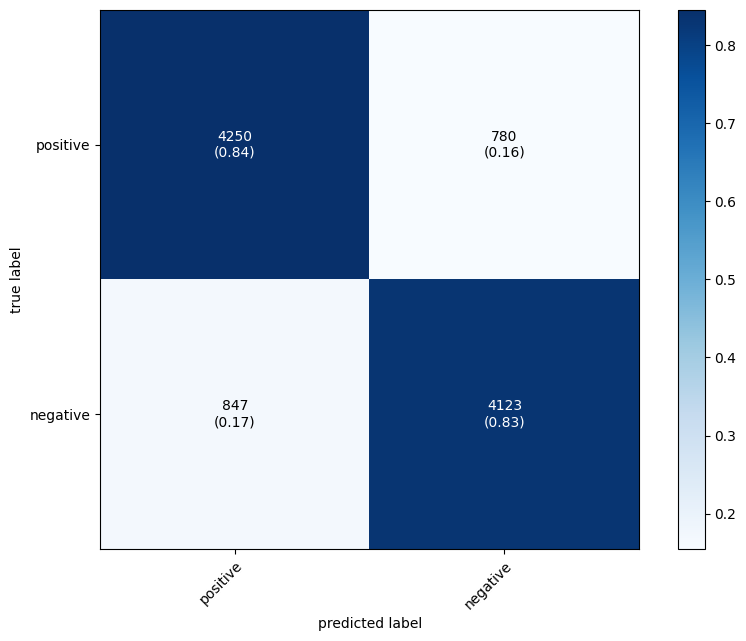

In [28]:
results_margin_sampling = active_learning(x_pool, y_pool, "margin_sampling", clf, 2, ["positive", "negative"])

## Entropy Sampling

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Starting Active Learning with entropy sampling method
Cycle: 1
	Training Accuracy: 0.502
	Testing Accuracy: 0.503
	Precision: 0.503
	Recall: 0.503
	F1 Score: 0.503
	Loss: 0.497
Cycle: 2
	Training Accuracy: 0.507
	Testing Accuracy: 0.508
	Precision: 0.508
	Recall: 0.508
	F1 Score: 0.508
	Loss: 0.492
Cycle: 3


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.527
	Testing Accuracy: 0.531
	Precision: 0.531
	Recall: 0.531
	F1 Score: 0.531
	Loss: 0.468
Cycle: 4
	Training Accuracy: 0.575
	Testing Accuracy: 0.577
	Precision: 0.577
	Recall: 0.577
	F1 Score: 0.577
	Loss: 0.423
Cycle: 5
	Training Accuracy: 0.653
	Testing Accuracy: 0.660
	Precision: 0.660
	Recall: 0.660
	F1 Score: 0.660
	Loss: 0.340
Cycle: 6


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.677
	Testing Accuracy: 0.681
	Precision: 0.681
	Recall: 0.681
	F1 Score: 0.681
	Loss: 0.319
Cycle: 7
	Training Accuracy: 0.706
	Testing Accuracy: 0.705
	Precision: 0.705
	Recall: 0.705
	F1 Score: 0.705
	Loss: 0.295
Cycle: 8
	Training Accuracy: 0.725
	Testing Accuracy: 0.725
	Precision: 0.725
	Recall: 0.725
	F1 Score: 0.725
	Loss: 0.275
Cycle: 9


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.735
	Testing Accuracy: 0.733
	Precision: 0.733
	Recall: 0.733
	F1 Score: 0.733
	Loss: 0.268
Cycle: 10
	Training Accuracy: 0.745
	Testing Accuracy: 0.743
	Precision: 0.743
	Recall: 0.743
	F1 Score: 0.743
	Loss: 0.257
	Slop after 10 Epochs tensor(-0.0266)
Cycle: 11
	Training Accuracy: 0.766
	Testing Accuracy: 0.757
	Precision: 0.757
	Recall: 0.757
	F1 Score: 0.757
	Loss: 0.243
	Slop after 10 Epochs tensor(-0.0277)
Cycle: 12


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.759
	Testing Accuracy: 0.751
	Precision: 0.751
	Recall: 0.751
	F1 Score: 0.751
	Loss: 0.249
	Slop after 10 Epochs tensor(-0.0244)
Cycle: 13
	Training Accuracy: 0.778
	Testing Accuracy: 0.770
	Precision: 0.770
	Recall: 0.770
	F1 Score: 0.770
	Loss: 0.230
	Slop after 10 Epochs tensor(-0.0214)
Cycle: 14
	Training Accuracy: 0.789
	Testing Accuracy: 0.780
	Precision: 0.780
	Recall: 0.780
	F1 Score: 0.780
	Loss: 0.220
	Slop after 10 Epochs tensor(-0.0134)
Cycle: 15


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.796
	Testing Accuracy: 0.787
	Precision: 0.787
	Recall: 0.787
	F1 Score: 0.787
	Loss: 0.213
	Slop after 10 Epochs tensor(-0.0118)
Cycle: 16
	Training Accuracy: 0.802
	Testing Accuracy: 0.794
	Precision: 0.794
	Recall: 0.794
	F1 Score: 0.794
	Loss: 0.206
	Slop after 10 Epochs tensor(-0.0098)
Cycle: 17
	Training Accuracy: 0.813
	Testing Accuracy: 0.804
	Precision: 0.804
	Recall: 0.804
	F1 Score: 0.804
	Loss: 0.196
	Slop after 10 Epochs tensor(-0.0088)
Cycle: 18


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.825
	Testing Accuracy: 0.812
	Precision: 0.812
	Recall: 0.812
	F1 Score: 0.812
	Loss: 0.188
	Slop after 10 Epochs tensor(-0.0089)
Cycle: 19
	Training Accuracy: 0.821
	Testing Accuracy: 0.808
	Precision: 0.808
	Recall: 0.808
	F1 Score: 0.808
	Loss: 0.192
	Slop after 10 Epochs tensor(-0.0073)
Cycle: 20
	Training Accuracy: 0.816
	Testing Accuracy: 0.808
	Precision: 0.808
	Recall: 0.808
	F1 Score: 0.808
	Loss: 0.192
	Slop after 10 Epochs tensor(-0.0056)
Cycle: 21


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.820
	Testing Accuracy: 0.807
	Precision: 0.807
	Recall: 0.807
	F1 Score: 0.807
	Loss: 0.193
	Slop after 10 Epochs tensor(-0.0062)
Cycle: 22
	Training Accuracy: 0.821
	Testing Accuracy: 0.812
	Precision: 0.812
	Recall: 0.812
	F1 Score: 0.812
	Loss: 0.188
	Slop after 10 Epochs tensor(-0.0047)
Cycle: 23
	Training Accuracy: 0.825
	Testing Accuracy: 0.815
	Precision: 0.815
	Recall: 0.815
	F1 Score: 0.815
	Loss: 0.185
	Slop after 10 Epochs tensor(-0.0039)
Cycle: 24


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.827
	Testing Accuracy: 0.814
	Precision: 0.814
	Recall: 0.814
	F1 Score: 0.814
	Loss: 0.186
	Slop after 10 Epochs tensor(-0.0029)
Cycle: 25
	Training Accuracy: 0.831
	Testing Accuracy: 0.816
	Precision: 0.816
	Recall: 0.816
	F1 Score: 0.816
	Loss: 0.184
	Slop after 10 Epochs tensor(-0.0024)
Cycle: 26
	Training Accuracy: 0.827
	Testing Accuracy: 0.815
	Precision: 0.815
	Recall: 0.815
	F1 Score: 0.815
	Loss: 0.185
	Slop after 10 Epochs tensor(-0.0013)
Cycle: 27


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.827
	Testing Accuracy: 0.814
	Precision: 0.814
	Recall: 0.814
	F1 Score: 0.814
	Loss: 0.186
	Slop after 10 Epochs tensor(-0.0001)
Cycle: 28
	Training Accuracy: 0.829
	Testing Accuracy: 0.817
	Precision: 0.817
	Recall: 0.817
	F1 Score: 0.817
	Loss: 0.183
	Slop after 10 Epochs tensor(-0.0010)
Cycle: 29
	Training Accuracy: 0.825
	Testing Accuracy: 0.815
	Precision: 0.815
	Recall: 0.815
	F1 Score: 0.815
	Loss: 0.185
	Slop after 10 Epochs tensor(-0.0008)
Cycle: 30


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.825
	Testing Accuracy: 0.813
	Precision: 0.813
	Recall: 0.813
	F1 Score: 0.813
	Loss: 0.187
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 31
	Training Accuracy: 0.830
	Testing Accuracy: 0.818
	Precision: 0.818
	Recall: 0.818
	F1 Score: 0.818
	Loss: 0.182
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 32
	Training Accuracy: 0.829
	Testing Accuracy: 0.818
	Precision: 0.818
	Recall: 0.818
	F1 Score: 0.818
	Loss: 0.182
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 33


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.831
	Testing Accuracy: 0.817
	Precision: 0.817
	Recall: 0.817
	F1 Score: 0.817
	Loss: 0.183
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 34
	Training Accuracy: 0.833
	Testing Accuracy: 0.822
	Precision: 0.822
	Recall: 0.822
	F1 Score: 0.822
	Loss: 0.178
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 35
	Training Accuracy: 0.836
	Testing Accuracy: 0.823
	Precision: 0.823
	Recall: 0.823
	F1 Score: 0.823
	Loss: 0.177
	Slop after 10 Epochs tensor(-0.0009)
Cycle: 36


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.840
	Testing Accuracy: 0.826
	Precision: 0.826
	Recall: 0.826
	F1 Score: 0.826
	Loss: 0.174
	Slop after 10 Epochs tensor(-0.0014)
Cycle: 37
	Training Accuracy: 0.839
	Testing Accuracy: 0.826
	Precision: 0.826
	Recall: 0.826
	F1 Score: 0.826
	Loss: 0.174
	Slop after 10 Epochs tensor(-0.0010)
Cycle: 38
	Training Accuracy: 0.842
	Testing Accuracy: 0.826
	Precision: 0.826
	Recall: 0.826
	F1 Score: 0.826
	Loss: 0.174
	Slop after 10 Epochs tensor(-0.0012)
Cycle: 39


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.842
	Testing Accuracy: 0.828
	Precision: 0.828
	Recall: 0.828
	F1 Score: 0.828
	Loss: 0.172
	Slop after 10 Epochs tensor(-0.0016)
Cycle: 40
	Training Accuracy: 0.842
	Testing Accuracy: 0.825
	Precision: 0.825
	Recall: 0.825
	F1 Score: 0.825
	Loss: 0.175
	Slop after 10 Epochs tensor(-0.0008)
Cycle: 41
	Training Accuracy: 0.845
	Testing Accuracy: 0.827
	Precision: 0.827
	Recall: 0.827
	F1 Score: 0.827
	Loss: 0.173
	Slop after 10 Epochs tensor(-0.0010)
Cycle: 42


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.849
	Testing Accuracy: 0.832
	Precision: 0.832
	Recall: 0.832
	F1 Score: 0.832
	Loss: 0.168
	Slop after 10 Epochs tensor(-0.0017)
Cycle: 43
	Training Accuracy: 0.849
	Testing Accuracy: 0.835
	Precision: 0.835
	Recall: 0.835
	F1 Score: 0.835
	Loss: 0.165
	Slop after 10 Epochs tensor(-0.0014)
Cycle: 44
	Training Accuracy: 0.844
	Testing Accuracy: 0.833
	Precision: 0.833
	Recall: 0.833
	F1 Score: 0.833
	Loss: 0.167
	Slop after 10 Epochs tensor(-0.0010)
Cycle: 45


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.844
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 46
	Training Accuracy: 0.845
	Testing Accuracy: 0.833
	Precision: 0.833
	Recall: 0.833
	F1 Score: 0.833
	Loss: 0.167
	Slop after 10 Epochs tensor(-0.0008)
Cycle: 47
	Training Accuracy: 0.847
	Testing Accuracy: 0.832
	Precision: 0.832
	Recall: 0.832
	F1 Score: 0.832
	Loss: 0.168
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 48


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.846
	Testing Accuracy: 0.833
	Precision: 0.833
	Recall: 0.833
	F1 Score: 0.833
	Loss: 0.167
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 49
	Training Accuracy: 0.847
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 50
	Training Accuracy: 0.846
	Testing Accuracy: 0.834
	Precision: 0.834
	Recall: 0.834
	F1 Score: 0.834
	Loss: 0.166
	Slop after 10 Epochs tensor(-0.0008)
Cycle: 51


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.849
	Testing Accuracy: 0.835
	Precision: 0.835
	Recall: 0.835
	F1 Score: 0.835
	Loss: 0.165
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 52
	Training Accuracy: 0.846
	Testing Accuracy: 0.833
	Precision: 0.833
	Recall: 0.833
	F1 Score: 0.833
	Loss: 0.167
	Slop after 10 Epochs tensor(0.0002)
Cycle: 53
	Training Accuracy: 0.846
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(0.0001)
Cycle: 54


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.845
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(5.5555e-05)
Cycle: 55
	Training Accuracy: 0.847
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(0.0001)
Cycle: 56
	Training Accuracy: 0.848
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(0.0002)
Cycle: 57


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.847
	Testing Accuracy: 0.828
	Precision: 0.828
	Recall: 0.828
	F1 Score: 0.828
	Loss: 0.172
	Slop after 10 Epochs tensor(0.0006)
Cycle: 58
	Training Accuracy: 0.850
	Testing Accuracy: 0.830
	Precision: 0.830
	Recall: 0.830
	F1 Score: 0.830
	Loss: 0.170
	Slop after 10 Epochs tensor(8.8889e-05)
Cycle: 59
	Training Accuracy: 0.851
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 0.171
	Slop after 10 Epochs tensor(0.0006)
Cycle: 60


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.852
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(0.0004)
Cycle: 61
	Training Accuracy: 0.851
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 0.171
	Slop after 10 Epochs tensor(0.0004)
Cycle: 62
	Training Accuracy: 0.852
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 0.171
	Slop after 10 Epochs tensor(0.0002)
Cycle: 63


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.852
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 0.171
	Slop after 10 Epochs tensor(0.0002)
Cycle: 64
	Training Accuracy: 0.852
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 0.171
	Slop after 10 Epochs tensor(0.0003)
Cycle: 65
	Training Accuracy: 0.852
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 0.171
	Slop after 10 Epochs tensor(0.0002)
Cycle: 66


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.851
	Testing Accuracy: 0.830
	Precision: 0.830
	Recall: 0.830
	F1 Score: 0.830
	Loss: 0.170
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 67
	Training Accuracy: 0.854
	Testing Accuracy: 0.830
	Precision: 0.830
	Recall: 0.830
	F1 Score: 0.830
	Loss: 0.170
	Slop after 10 Epochs tensor(8.8889e-05)
Cycle: 68
	Training Accuracy: 0.856
	Testing Accuracy: 0.833
	Precision: 0.833
	Recall: 0.833
	F1 Score: 0.833
	Loss: 0.167
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 69


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.855
	Testing Accuracy: 0.830
	Precision: 0.830
	Recall: 0.830
	F1 Score: 0.830
	Loss: 0.170
	Slop after 10 Epochs tensor(0.0001)
Cycle: 70
	Training Accuracy: 0.856
	Testing Accuracy: 0.826
	Precision: 0.826
	Recall: 0.826
	F1 Score: 0.826
	Loss: 0.174
	Slop after 10 Epochs tensor(0.0003)
Cycle: 71
	Training Accuracy: 0.856
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 0.171
	Slop after 10 Epochs tensor(6.6666e-05)
Cycle: 72


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.856
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 73
	Training Accuracy: 0.857
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 74
	Training Accuracy: 0.858
	Testing Accuracy: 0.835
	Precision: 0.835
	Recall: 0.835
	F1 Score: 0.835
	Loss: 0.165
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 75


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.856
	Testing Accuracy: 0.833
	Precision: 0.833
	Recall: 0.833
	F1 Score: 0.833
	Loss: 0.167
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 76
	Training Accuracy: 0.856
	Testing Accuracy: 0.833
	Precision: 0.833
	Recall: 0.833
	F1 Score: 0.833
	Loss: 0.167
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 77
	Training Accuracy: 0.858
	Testing Accuracy: 0.834
	Precision: 0.834
	Recall: 0.834
	F1 Score: 0.834
	Loss: 0.166
	Slop after 10 Epochs tensor(-0.0001)
Cycle: 78


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.859
	Testing Accuracy: 0.836
	Precision: 0.836
	Recall: 0.836
	F1 Score: 0.836
	Loss: 0.164
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 79
	Training Accuracy: 0.860
	Testing Accuracy: 0.837
	Precision: 0.837
	Recall: 0.837
	F1 Score: 0.837
	Loss: 0.163
	Slop after 10 Epochs tensor(-0.0012)
Cycle: 80
	Training Accuracy: 0.861
	Testing Accuracy: 0.837
	Precision: 0.837
	Recall: 0.837
	F1 Score: 0.837
	Loss: 0.163
	Slop after 10 Epochs tensor(-0.0009)
Cycle: 81


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.863
	Testing Accuracy: 0.836
	Precision: 0.836
	Recall: 0.836
	F1 Score: 0.836
	Loss: 0.164
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 82
	Training Accuracy: 0.864
	Testing Accuracy: 0.839
	Precision: 0.839
	Recall: 0.839
	F1 Score: 0.839
	Loss: 0.161
	Slop after 10 Epochs tensor(-0.0009)
Cycle: 83
	Training Accuracy: 0.862
	Testing Accuracy: 0.840
	Precision: 0.840
	Recall: 0.840
	F1 Score: 0.840
	Loss: 0.160
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 84


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.861
	Testing Accuracy: 0.839
	Precision: 0.839
	Recall: 0.839
	F1 Score: 0.839
	Loss: 0.161
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 85
	Training Accuracy: 0.862
	Testing Accuracy: 0.839
	Precision: 0.839
	Recall: 0.839
	F1 Score: 0.839
	Loss: 0.161
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 86
	Training Accuracy: 0.863
	Testing Accuracy: 0.838
	Precision: 0.838
	Recall: 0.838
	F1 Score: 0.838
	Loss: 0.162
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 87


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.864
	Testing Accuracy: 0.840
	Precision: 0.840
	Recall: 0.840
	F1 Score: 0.840
	Loss: 0.160
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 88
	Training Accuracy: 0.862
	Testing Accuracy: 0.839
	Precision: 0.839
	Recall: 0.839
	F1 Score: 0.839
	Loss: 0.161
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 89
	Training Accuracy: 0.862
	Testing Accuracy: 0.839
	Precision: 0.839
	Recall: 0.839
	F1 Score: 0.839
	Loss: 0.161
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 90


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.862
	Testing Accuracy: 0.838
	Precision: 0.838
	Recall: 0.838
	F1 Score: 0.838
	Loss: 0.162
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 91
	Training Accuracy: 0.862
	Testing Accuracy: 0.840
	Precision: 0.840
	Recall: 0.840
	F1 Score: 0.840
	Loss: 0.160
	Slop after 10 Epochs tensor(-0.0001)
Cycle: 92
	Training Accuracy: 0.861
	Testing Accuracy: 0.840
	Precision: 0.840
	Recall: 0.840
	F1 Score: 0.840
	Loss: 0.160
	Slop after 10 Epochs tensor(1.1111e-05)
Cycle: 93


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.863
	Testing Accuracy: 0.842
	Precision: 0.842
	Recall: 0.842
	F1 Score: 0.842
	Loss: 0.158
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 94
	Training Accuracy: 0.865
	Testing Accuracy: 0.841
	Precision: 0.841
	Recall: 0.841
	F1 Score: 0.841
	Loss: 0.159
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 95
	Training Accuracy: 0.866
	Testing Accuracy: 0.840
	Precision: 0.840
	Recall: 0.840
	F1 Score: 0.840
	Loss: 0.160
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 96


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.867
	Testing Accuracy: 0.842
	Precision: 0.842
	Recall: 0.842
	F1 Score: 0.842
	Loss: 0.158
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 97
	Training Accuracy: 0.866
	Testing Accuracy: 0.842
	Precision: 0.842
	Recall: 0.842
	F1 Score: 0.842
	Loss: 0.158
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 98
	Training Accuracy: 0.865
	Testing Accuracy: 0.841
	Precision: 0.841
	Recall: 0.841
	F1 Score: 0.841
	Loss: 0.159
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 99


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.866
	Testing Accuracy: 0.843
	Precision: 0.843
	Recall: 0.843
	F1 Score: 0.843
	Loss: 0.157
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 100
	Training Accuracy: 0.865
	Testing Accuracy: 0.845
	Precision: 0.845
	Recall: 0.845
	F1 Score: 0.845
	Loss: 0.155
	Slop after 10 Epochs tensor(-0.0006)
Active Learning with entropy_sampling method is finished


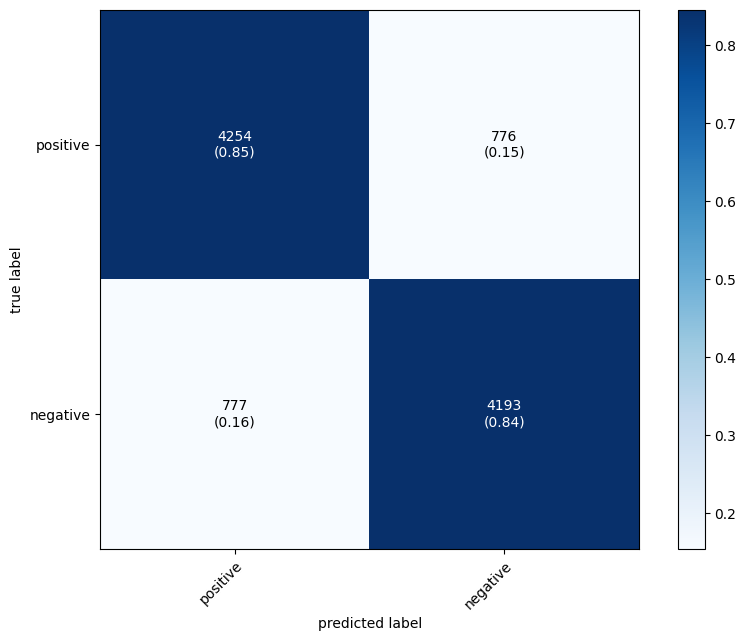

In [29]:
results_entropy_sampling = active_learning(x_pool, y_pool, "entropy_sampling", clf, 2, ["positive", "negative"])

## Query by Committee

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Starting Active Learning with query by committee method
Cycle: 1


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.498
	Testing Accuracy: 0.497
	Precision: 0.497
	Recall: 0.497
	F1 Score: 0.497
	Loss: 0.503
Cycle: 2


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.583
	Testing Accuracy: 0.578
	Precision: 0.578
	Recall: 0.578
	F1 Score: 0.578
	Loss: 0.422
Cycle: 3


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.498
	Testing Accuracy: 0.497
	Precision: 0.497
	Recall: 0.497
	F1 Score: 0.497
	Loss: 0.503
Cycle: 4


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.501
	Testing Accuracy: 0.500
	Precision: 0.500
	Recall: 0.500
	F1 Score: 0.500
	Loss: 0.500
Cycle: 5


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.527
	Testing Accuracy: 0.530
	Precision: 0.530
	Recall: 0.530
	F1 Score: 0.530
	Loss: 0.470
Cycle: 6


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.585
	Testing Accuracy: 0.585
	Precision: 0.585
	Recall: 0.585
	F1 Score: 0.585
	Loss: 0.415
Cycle: 7


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.683
	Testing Accuracy: 0.681
	Precision: 0.681
	Recall: 0.681
	F1 Score: 0.681
	Loss: 0.319
Cycle: 8


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.668
	Testing Accuracy: 0.668
	Precision: 0.668
	Recall: 0.668
	F1 Score: 0.668
	Loss: 0.332
Cycle: 9


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.679
	Testing Accuracy: 0.676
	Precision: 0.676
	Recall: 0.676
	F1 Score: 0.676
	Loss: 0.324
Cycle: 10


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.738
	Testing Accuracy: 0.736
	Precision: 0.736
	Recall: 0.736
	F1 Score: 0.736
	Loss: 0.264
	Slop after 10 Epochs tensor(-0.0266)
Cycle: 11


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.764
	Testing Accuracy: 0.757
	Precision: 0.757
	Recall: 0.757
	F1 Score: 0.757
	Loss: 0.243
	Slop after 10 Epochs tensor(-0.0199)
Cycle: 12


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.779
	Testing Accuracy: 0.775
	Precision: 0.775
	Recall: 0.775
	F1 Score: 0.775
	Loss: 0.225
	Slop after 10 Epochs tensor(-0.0309)
Cycle: 13


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.774
	Testing Accuracy: 0.772
	Precision: 0.772
	Recall: 0.772
	F1 Score: 0.772
	Loss: 0.228
	Slop after 10 Epochs tensor(-0.0302)
Cycle: 14


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.790
	Testing Accuracy: 0.786
	Precision: 0.786
	Recall: 0.786
	F1 Score: 0.786
	Loss: 0.214
	Slop after 10 Epochs tensor(-0.0284)
Cycle: 15


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.788
	Testing Accuracy: 0.786
	Precision: 0.786
	Recall: 0.786
	F1 Score: 0.786
	Loss: 0.214
	Slop after 10 Epochs tensor(-0.0223)
Cycle: 16


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.790
	Testing Accuracy: 0.789
	Precision: 0.789
	Recall: 0.789
	F1 Score: 0.789
	Loss: 0.211
	Slop after 10 Epochs tensor(-0.0120)
Cycle: 17


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.787
	Testing Accuracy: 0.785
	Precision: 0.785
	Recall: 0.785
	F1 Score: 0.785
	Loss: 0.215
	Slop after 10 Epochs tensor(-0.0130)
Cycle: 18


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.776
	Testing Accuracy: 0.778
	Precision: 0.778
	Recall: 0.778
	F1 Score: 0.778
	Loss: 0.222
	Slop after 10 Epochs tensor(-0.0114)
Cycle: 19


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.776
	Testing Accuracy: 0.778
	Precision: 0.778
	Recall: 0.778
	F1 Score: 0.778
	Loss: 0.222
	Slop after 10 Epochs tensor(-0.0046)
Cycle: 20


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.790
	Testing Accuracy: 0.790
	Precision: 0.790
	Recall: 0.790
	F1 Score: 0.790
	Loss: 0.210
	Slop after 10 Epochs tensor(-0.0037)
Cycle: 21


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.788
	Testing Accuracy: 0.787
	Precision: 0.787
	Recall: 0.787
	F1 Score: 0.787
	Loss: 0.213
	Slop after 10 Epochs tensor(-0.0013)
Cycle: 22


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.788
	Testing Accuracy: 0.787
	Precision: 0.787
	Recall: 0.787
	F1 Score: 0.787
	Loss: 0.213
	Slop after 10 Epochs tensor(-0.0017)
Cycle: 23


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.794
	Testing Accuracy: 0.790
	Precision: 0.790
	Recall: 0.790
	F1 Score: 0.790
	Loss: 0.209
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 24


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.794
	Testing Accuracy: 0.792
	Precision: 0.792
	Recall: 0.792
	F1 Score: 0.792
	Loss: 0.208
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 25


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.797
	Testing Accuracy: 0.796
	Precision: 0.796
	Recall: 0.796
	F1 Score: 0.796
	Loss: 0.204
	Slop after 10 Epochs tensor(-0.0008)
Cycle: 26


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.797
	Testing Accuracy: 0.797
	Precision: 0.797
	Recall: 0.797
	F1 Score: 0.797
	Loss: 0.203
	Slop after 10 Epochs tensor(-0.0014)
Cycle: 27


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.798
	Testing Accuracy: 0.798
	Precision: 0.798
	Recall: 0.798
	F1 Score: 0.798
	Loss: 0.202
	Slop after 10 Epochs tensor(-0.0022)
Cycle: 28


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.797
	Testing Accuracy: 0.796
	Precision: 0.796
	Recall: 0.796
	F1 Score: 0.796
	Loss: 0.204
	Slop after 10 Epochs tensor(-0.0021)
Cycle: 29


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.797
	Testing Accuracy: 0.799
	Precision: 0.799
	Recall: 0.799
	F1 Score: 0.799
	Loss: 0.201
	Slop after 10 Epochs tensor(-0.0010)
Cycle: 30


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.795
	Testing Accuracy: 0.797
	Precision: 0.797
	Recall: 0.797
	F1 Score: 0.797
	Loss: 0.203
	Slop after 10 Epochs tensor(-0.0011)
Cycle: 31


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.794
	Testing Accuracy: 0.797
	Precision: 0.797
	Recall: 0.797
	F1 Score: 0.797
	Loss: 0.203
	Slop after 10 Epochs tensor(-0.0012)
Cycle: 32


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.796
	Testing Accuracy: 0.800
	Precision: 0.800
	Recall: 0.800
	F1 Score: 0.800
	Loss: 0.200
	Slop after 10 Epochs tensor(-0.0010)
Cycle: 33


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.797
	Testing Accuracy: 0.800
	Precision: 0.800
	Recall: 0.800
	F1 Score: 0.801
	Loss: 0.199
	Slop after 10 Epochs tensor(-0.0009)
Cycle: 34


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.798
	Testing Accuracy: 0.801
	Precision: 0.801
	Recall: 0.801
	F1 Score: 0.801
	Loss: 0.199
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 35


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.798
	Testing Accuracy: 0.802
	Precision: 0.802
	Recall: 0.802
	F1 Score: 0.802
	Loss: 0.198
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 36


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.800
	Testing Accuracy: 0.802
	Precision: 0.802
	Recall: 0.802
	F1 Score: 0.802
	Loss: 0.198
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 37


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.805
	Testing Accuracy: 0.803
	Precision: 0.803
	Recall: 0.803
	F1 Score: 0.803
	Loss: 0.197
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 38


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.805
	Testing Accuracy: 0.804
	Precision: 0.804
	Recall: 0.804
	F1 Score: 0.804
	Loss: 0.196
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 39


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.805
	Testing Accuracy: 0.804
	Precision: 0.804
	Recall: 0.804
	F1 Score: 0.804
	Loss: 0.196
	Slop after 10 Epochs tensor(-0.0008)
Cycle: 40


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.807
	Testing Accuracy: 0.804
	Precision: 0.804
	Recall: 0.804
	F1 Score: 0.804
	Loss: 0.196
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 41


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.808
	Testing Accuracy: 0.805
	Precision: 0.805
	Recall: 0.805
	F1 Score: 0.805
	Loss: 0.195
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 42


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.810
	Testing Accuracy: 0.806
	Precision: 0.806
	Recall: 0.806
	F1 Score: 0.806
	Loss: 0.194
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 43


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.809
	Testing Accuracy: 0.804
	Precision: 0.804
	Recall: 0.804
	F1 Score: 0.804
	Loss: 0.196
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 44


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.807
	Testing Accuracy: 0.804
	Precision: 0.804
	Recall: 0.804
	F1 Score: 0.804
	Loss: 0.196
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 45


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.812
	Testing Accuracy: 0.808
	Precision: 0.808
	Recall: 0.808
	F1 Score: 0.808
	Loss: 0.192
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 46


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.811
	Testing Accuracy: 0.808
	Precision: 0.808
	Recall: 0.808
	F1 Score: 0.808
	Loss: 0.192
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 47


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.810
	Testing Accuracy: 0.806
	Precision: 0.806
	Recall: 0.806
	F1 Score: 0.806
	Loss: 0.194
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 48


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.811
	Testing Accuracy: 0.807
	Precision: 0.807
	Recall: 0.807
	F1 Score: 0.807
	Loss: 0.193
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 49


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.812
	Testing Accuracy: 0.809
	Precision: 0.809
	Recall: 0.809
	F1 Score: 0.809
	Loss: 0.191
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 50


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.816
	Testing Accuracy: 0.814
	Precision: 0.814
	Recall: 0.814
	F1 Score: 0.814
	Loss: 0.186
	Slop after 10 Epochs tensor(-0.0010)
Cycle: 51


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.817
	Testing Accuracy: 0.812
	Precision: 0.812
	Recall: 0.812
	F1 Score: 0.812
	Loss: 0.188
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 52


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.819
	Testing Accuracy: 0.813
	Precision: 0.813
	Recall: 0.813
	F1 Score: 0.813
	Loss: 0.187
	Slop after 10 Epochs tensor(-0.0010)
Cycle: 53


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.820
	Testing Accuracy: 0.813
	Precision: 0.813
	Recall: 0.813
	F1 Score: 0.813
	Loss: 0.187
	Slop after 10 Epochs tensor(-0.0010)
Cycle: 54


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.820
	Testing Accuracy: 0.814
	Precision: 0.814
	Recall: 0.814
	F1 Score: 0.814
	Loss: 0.186
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 55


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.820
	Testing Accuracy: 0.815
	Precision: 0.815
	Recall: 0.815
	F1 Score: 0.815
	Loss: 0.185
	Slop after 10 Epochs tensor(-0.0008)
Cycle: 56


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.819
	Testing Accuracy: 0.816
	Precision: 0.816
	Recall: 0.816
	F1 Score: 0.816
	Loss: 0.184
	Slop after 10 Epochs tensor(-0.0011)
Cycle: 57


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.819
	Testing Accuracy: 0.815
	Precision: 0.815
	Recall: 0.815
	F1 Score: 0.815
	Loss: 0.185
	Slop after 10 Epochs tensor(-0.0009)
Cycle: 58


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.820
	Testing Accuracy: 0.816
	Precision: 0.816
	Recall: 0.816
	F1 Score: 0.816
	Loss: 0.184
	Slop after 10 Epochs tensor(-0.0007)
Cycle: 59


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.821
	Testing Accuracy: 0.817
	Precision: 0.817
	Recall: 0.817
	F1 Score: 0.817
	Loss: 0.183
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 60


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.821
	Testing Accuracy: 0.816
	Precision: 0.816
	Recall: 0.816
	F1 Score: 0.816
	Loss: 0.184
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 61


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.819
	Testing Accuracy: 0.817
	Precision: 0.817
	Recall: 0.817
	F1 Score: 0.817
	Loss: 0.183
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 62


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.817
	Testing Accuracy: 0.814
	Precision: 0.814
	Recall: 0.814
	F1 Score: 0.814
	Loss: 0.186
	Slop after 10 Epochs tensor(-0.0001)
Cycle: 63


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.818
	Testing Accuracy: 0.818
	Precision: 0.818
	Recall: 0.818
	F1 Score: 0.818
	Loss: 0.182
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 64


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.818
	Testing Accuracy: 0.816
	Precision: 0.816
	Recall: 0.816
	F1 Score: 0.816
	Loss: 0.184
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 65


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.819
	Testing Accuracy: 0.818
	Precision: 0.818
	Recall: 0.818
	F1 Score: 0.818
	Loss: 0.182
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 66


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.821
	Testing Accuracy: 0.817
	Precision: 0.817
	Recall: 0.817
	F1 Score: 0.817
	Loss: 0.183
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 67


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.823
	Testing Accuracy: 0.821
	Precision: 0.821
	Recall: 0.821
	F1 Score: 0.821
	Loss: 0.179
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 68


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.824
	Testing Accuracy: 0.820
	Precision: 0.820
	Recall: 0.820
	F1 Score: 0.820
	Loss: 0.180
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 69


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.826
	Testing Accuracy: 0.821
	Precision: 0.821
	Recall: 0.821
	F1 Score: 0.821
	Loss: 0.179
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 70


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.826
	Testing Accuracy: 0.821
	Precision: 0.821
	Recall: 0.821
	F1 Score: 0.821
	Loss: 0.179
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 71


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.826
	Testing Accuracy: 0.822
	Precision: 0.822
	Recall: 0.822
	F1 Score: 0.822
	Loss: 0.178
	Slop after 10 Epochs tensor(-0.0008)
Cycle: 72


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.826
	Testing Accuracy: 0.822
	Precision: 0.822
	Recall: 0.822
	F1 Score: 0.822
	Loss: 0.178
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 73


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.826
	Testing Accuracy: 0.821
	Precision: 0.821
	Recall: 0.821
	F1 Score: 0.821
	Loss: 0.179
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 74


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.827
	Testing Accuracy: 0.822
	Precision: 0.822
	Recall: 0.822
	F1 Score: 0.822
	Loss: 0.178
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 75


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.827
	Testing Accuracy: 0.821
	Precision: 0.821
	Recall: 0.821
	F1 Score: 0.821
	Loss: 0.179
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 76


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.828
	Testing Accuracy: 0.822
	Precision: 0.822
	Recall: 0.822
	F1 Score: 0.822
	Loss: 0.178
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 77


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.828
	Testing Accuracy: 0.825
	Precision: 0.825
	Recall: 0.825
	F1 Score: 0.825
	Loss: 0.175
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 78


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.830
	Testing Accuracy: 0.825
	Precision: 0.825
	Recall: 0.825
	F1 Score: 0.825
	Loss: 0.175
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 79


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.831
	Testing Accuracy: 0.825
	Precision: 0.825
	Recall: 0.825
	F1 Score: 0.825
	Loss: 0.175
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 80


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.832
	Testing Accuracy: 0.827
	Precision: 0.827
	Recall: 0.827
	F1 Score: 0.827
	Loss: 0.173
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 81


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.833
	Testing Accuracy: 0.827
	Precision: 0.827
	Recall: 0.827
	F1 Score: 0.827
	Loss: 0.173
	Slop after 10 Epochs tensor(-0.0005)
Cycle: 82


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.832
	Testing Accuracy: 0.826
	Precision: 0.826
	Recall: 0.826
	F1 Score: 0.826
	Loss: 0.174
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 83


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.832
	Testing Accuracy: 0.827
	Precision: 0.827
	Recall: 0.827
	F1 Score: 0.827
	Loss: 0.173
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 84


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.832
	Testing Accuracy: 0.830
	Precision: 0.830
	Recall: 0.830
	F1 Score: 0.830
	Loss: 0.170
	Slop after 10 Epochs tensor(-0.0010)
Cycle: 85


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.833
	Testing Accuracy: 0.828
	Precision: 0.828
	Recall: 0.828
	F1 Score: 0.828
	Loss: 0.172
	Slop after 10 Epochs tensor(-0.0006)
Cycle: 86


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.833
	Testing Accuracy: 0.827
	Precision: 0.827
	Recall: 0.827
	F1 Score: 0.827
	Loss: 0.173
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 87


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.833
	Testing Accuracy: 0.827
	Precision: 0.827
	Recall: 0.827
	F1 Score: 0.827
	Loss: 0.173
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 88


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.833
	Testing Accuracy: 0.827
	Precision: 0.827
	Recall: 0.827
	F1 Score: 0.827
	Loss: 0.173
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 89


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.835
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 0.171
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 90


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.835
	Testing Accuracy: 0.828
	Precision: 0.828
	Recall: 0.828
	F1 Score: 0.828
	Loss: 0.172
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 91


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.834
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 0.171
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 92


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.837
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 0.171
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 93


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.835
	Testing Accuracy: 0.830
	Precision: 0.830
	Recall: 0.830
	F1 Score: 0.830
	Loss: 0.170
	Slop after 10 Epochs tensor(6.6666e-05)
Cycle: 94


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.835
	Testing Accuracy: 0.830
	Precision: 0.830
	Recall: 0.830
	F1 Score: 0.830
	Loss: 0.170
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 95


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.835
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 0.171
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 96


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.834
	Testing Accuracy: 0.830
	Precision: 0.830
	Recall: 0.830
	F1 Score: 0.830
	Loss: 0.170
	Slop after 10 Epochs tensor(-0.0004)
Cycle: 97


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.835
	Testing Accuracy: 0.830
	Precision: 0.830
	Recall: 0.830
	F1 Score: 0.830
	Loss: 0.170
	Slop after 10 Epochs tensor(-0.0003)
Cycle: 98


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.837
	Testing Accuracy: 0.830
	Precision: 0.830
	Recall: 0.830
	F1 Score: 0.830
	Loss: 0.170
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 99


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation

	Training Accuracy: 0.837
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 0.169
	Slop after 10 Epochs tensor(-0.0002)
Cycle: 100


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


	Training Accuracy: 0.838
	Testing Accuracy: 0.830
	Precision: 0.830
	Recall: 0.830
	F1 Score: 0.830
	Loss: 0.170
	Slop after 10 Epochs tensor(-0.0001)
Active Learning with query_by_committee method is finished


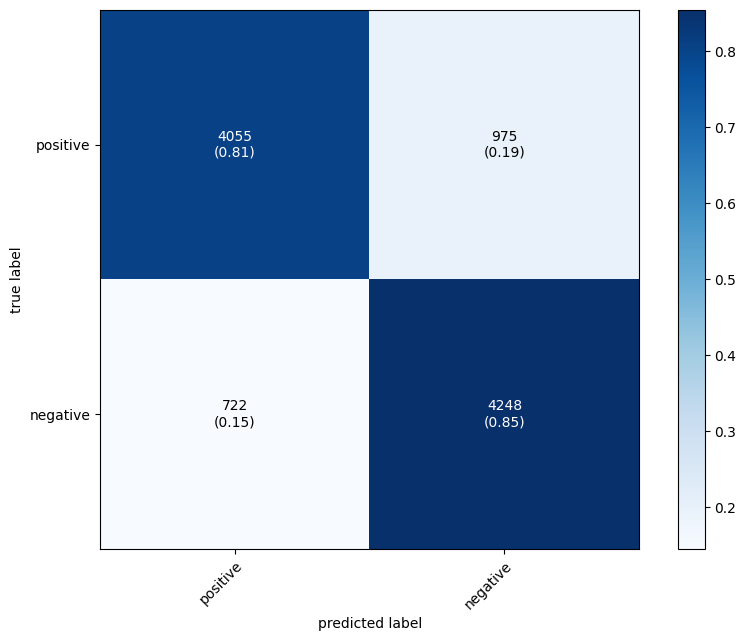

In [30]:
results_committee_sampling = active_learning(x_pool, y_pool, "query_by_committee", clf, 2, ["positive", "negative"])

# Plot All Metrics


# Accuracy


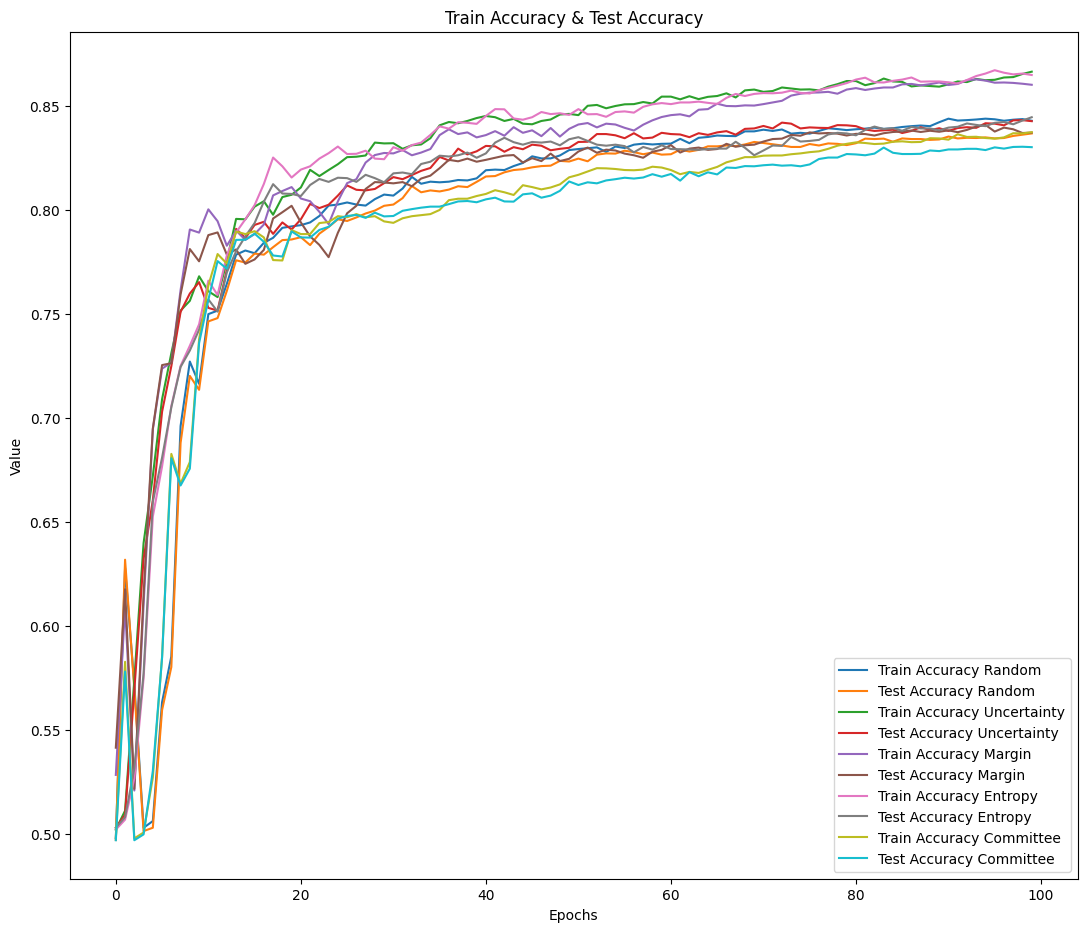

Train Accuracy Random: 0.843
Test Accuracy Random: 0.836899995803833
Train Accuracy Uncertainty: 0.8666
Test Accuracy Uncertainty: 0.8428000211715698
Train Accuracy Margin: 0.8603
Test Accuracy Margin: 0.8373000025749207
Train Accuracy Entropy: 0.865
Test Accuracy Entropy: 0.8446999788284302
Train Accuracy Committee: 0.8375
Test Accuracy Committee: 0.830299973487854


In [31]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["Train Accuracy"], label="Train Accuracy Random")
plt.plot(results_random_sampling["Test Accuracy"], label="Test Accuracy Random")
plt.plot(results_uncertainty_sampling["Train Accuracy"], label="Train Accuracy Uncertainty")
plt.plot(results_uncertainty_sampling["Test Accuracy"], label="Test Accuracy Uncertainty")
plt.plot(results_margin_sampling["Train Accuracy"], label="Train Accuracy Margin")
plt.plot(results_margin_sampling["Test Accuracy"], label="Test Accuracy Margin")
plt.plot(results_entropy_sampling["Train Accuracy"], label="Train Accuracy Entropy")
plt.plot(results_entropy_sampling["Test Accuracy"], label="Test Accuracy Entropy")
plt.plot(results_committee_sampling["Train Accuracy"], label="Train Accuracy Committee")
plt.plot(results_committee_sampling["Test Accuracy"], label="Test Accuracy Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Train Accuracy & Test Accuracy")
plt.legend()
plt.savefig("reports/model_after_al_accuracy.png")
plt.show()

print(f"Train Accuracy Random: {results_random_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Random: {results_random_sampling['Test Accuracy'][-1]}")
print(f"Train Accuracy Uncertainty: {results_uncertainty_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Uncertainty: {results_uncertainty_sampling['Test Accuracy'][-1]}")
print(f"Train Accuracy Margin: {results_margin_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Margin: {results_margin_sampling['Test Accuracy'][-1]}")
print(f"Train Accuracy Entropy: {results_entropy_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Entropy: {results_entropy_sampling['Test Accuracy'][-1]}")
print(f"Train Accuracy Committee: {results_committee_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Committee: {results_committee_sampling['Test Accuracy'][-1]}")

## Loss

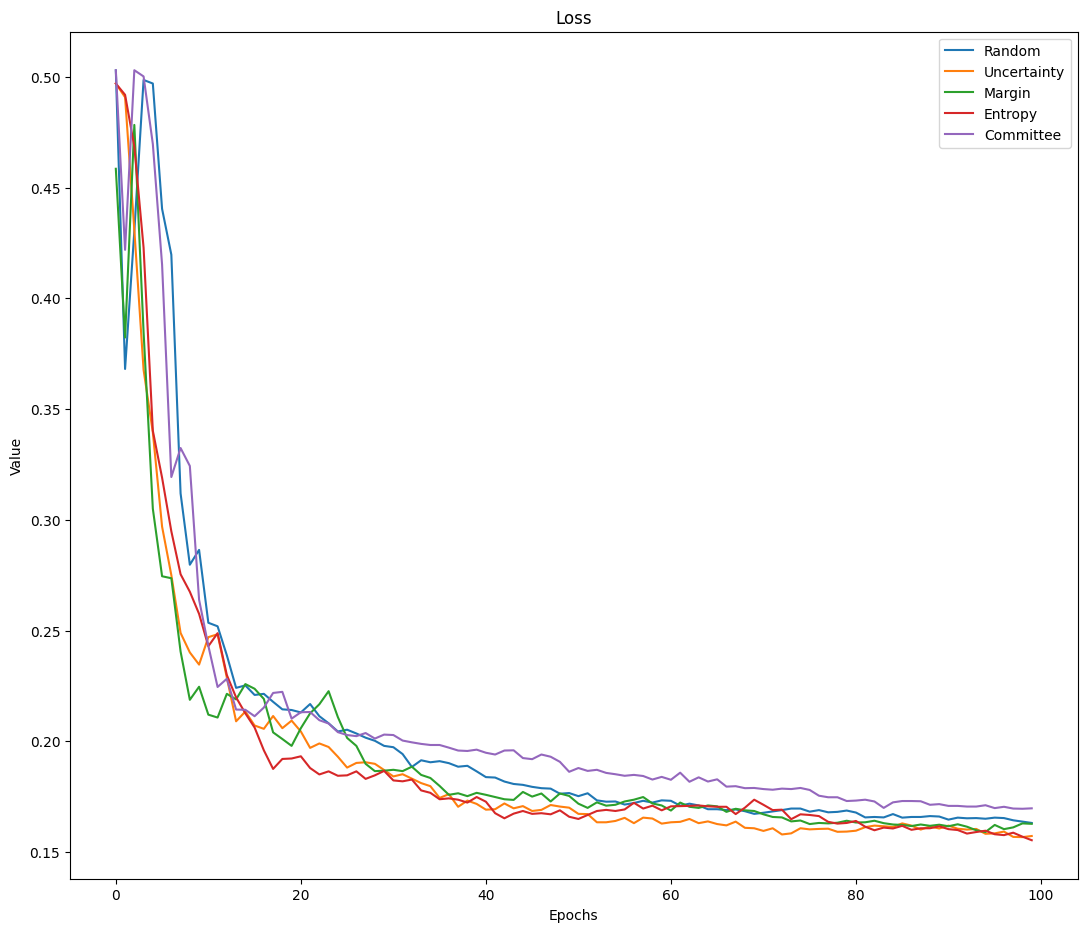

Random: 0.163100004196167
Uncertainty: 0.15719999372959137
Margin: 0.16269999742507935
Entropy: 0.15530000627040863
Committee: 0.1696999967098236


In [32]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["Loss"], label="Random")
plt.plot(results_uncertainty_sampling["Loss"], label="Uncertainty")
plt.plot(results_margin_sampling["Loss"], label="Margin")
plt.plot(results_entropy_sampling["Loss"], label="Entropy")
plt.plot(results_committee_sampling["Loss"], label="Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Loss")
plt.legend()
plt.savefig("reports/model_after_al_loss.png")
plt.show()

print(f"Random: {results_random_sampling['Loss'][-1]}")
print(f"Uncertainty: {results_uncertainty_sampling['Loss'][-1]}")
print(f"Margin: {results_margin_sampling['Loss'][-1]}")
print(f"Entropy: {results_entropy_sampling['Loss'][-1]}")
print(f"Committee: {results_committee_sampling['Loss'][-1]}")

# Precision


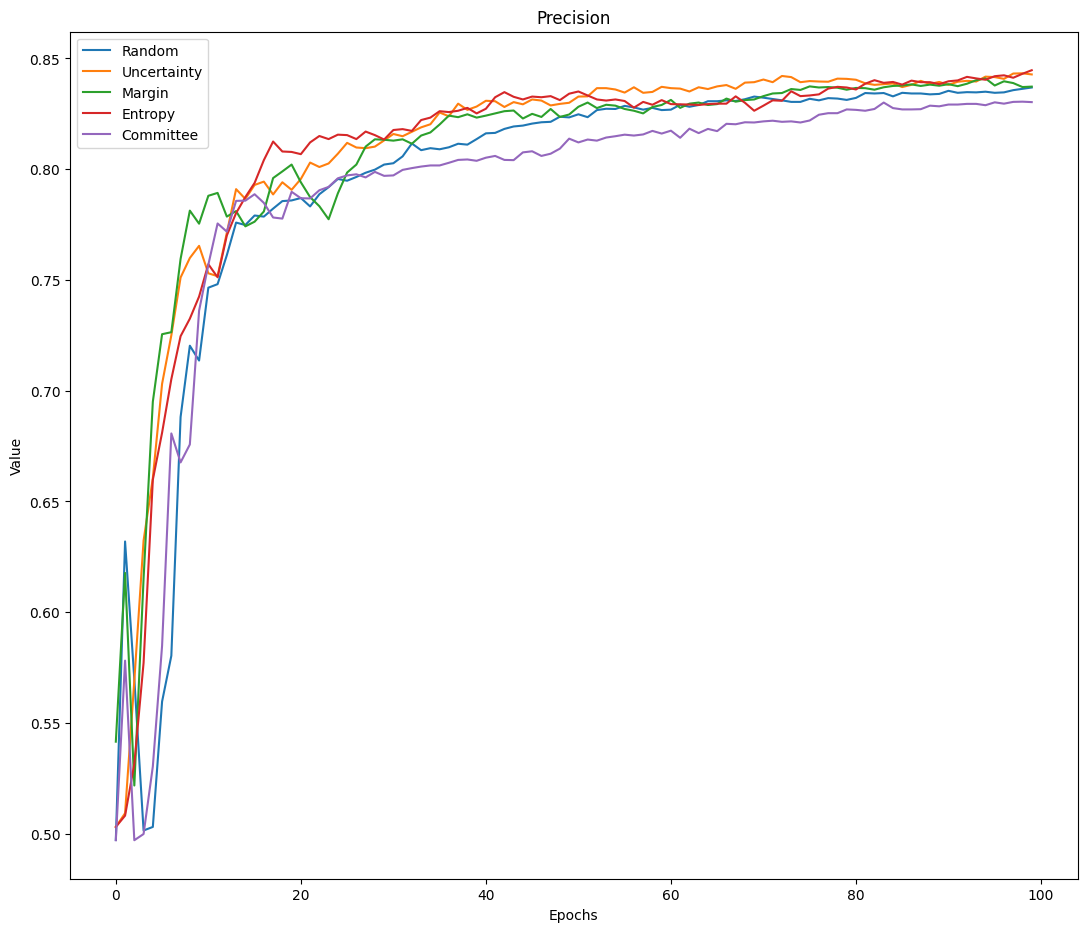

Random: 0.836899995803833
Uncertainty: 0.8428000211715698
Margin: 0.8373000025749207
Entropy: 0.8446999788284302
Committee: 0.830299973487854


In [33]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["Precision"], label="Random")
plt.plot(results_uncertainty_sampling["Precision"], label="Uncertainty")
plt.plot(results_margin_sampling["Precision"], label="Margin")
plt.plot(results_entropy_sampling["Precision"], label="Entropy")
plt.plot(results_committee_sampling["Precision"], label="Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Precision")
plt.legend()
plt.savefig("reports/model_after_al_precision.png")
plt.show()

print(f"Random: {results_random_sampling['Precision'][-1]}")
print(f"Uncertainty: {results_uncertainty_sampling['Precision'][-1]}")
print(f"Margin: {results_margin_sampling['Precision'][-1]}")
print(f"Entropy: {results_entropy_sampling['Precision'][-1]}")
print(f"Committee: {results_committee_sampling['Precision'][-1]}")

# Recall


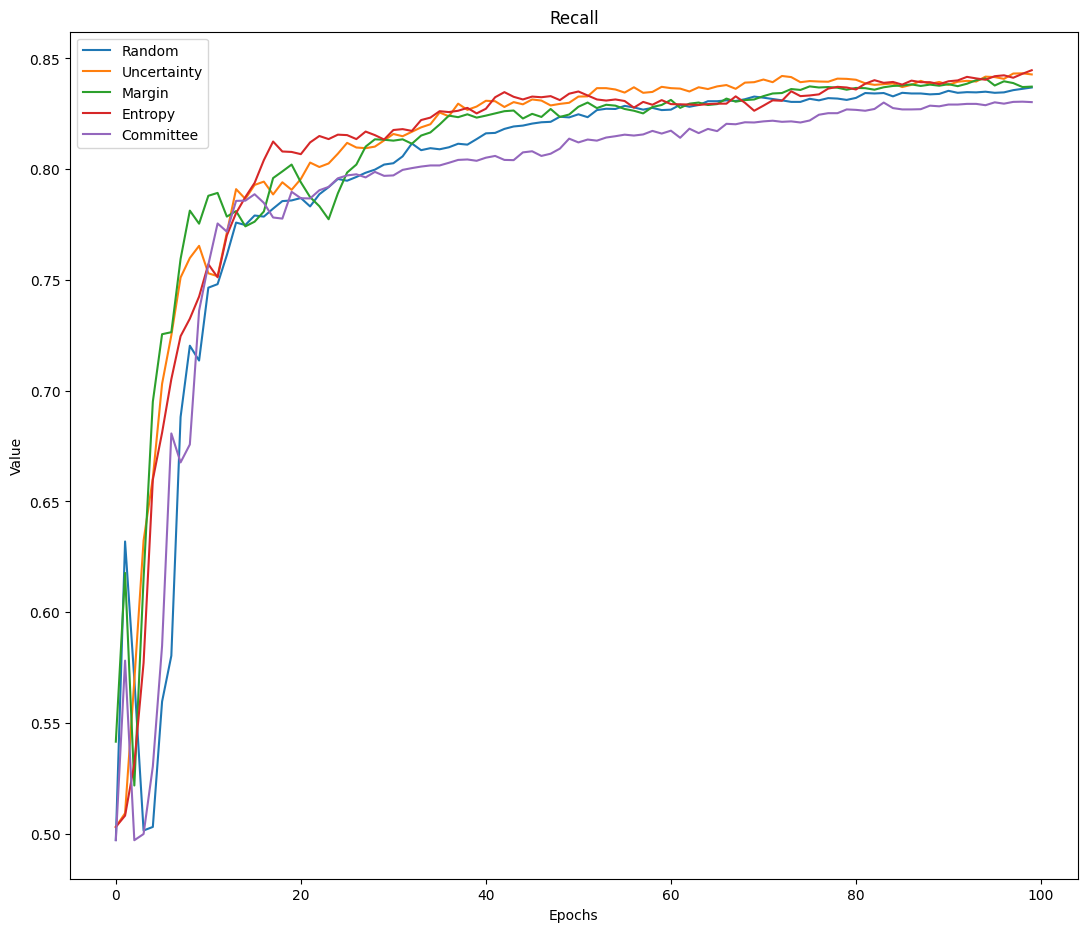

Random: 0.836899995803833
Uncertainty: 0.8428000211715698
Margin: 0.8373000025749207
Entropy: 0.8446999788284302
Committee: 0.830299973487854


In [34]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["Recall"], label="Random")
plt.plot(results_uncertainty_sampling["Recall"], label="Uncertainty")
plt.plot(results_margin_sampling["Recall"], label="Margin")
plt.plot(results_entropy_sampling["Recall"], label="Entropy")
plt.plot(results_committee_sampling["Recall"], label="Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Recall")
plt.legend()
plt.savefig("reports/model_after_al_recall.png")
plt.show()

print(f"Random: {results_random_sampling['Recall'][-1]}")
print(f"Uncertainty: {results_uncertainty_sampling['Recall'][-1]}")
print(f"Margin: {results_margin_sampling['Recall'][-1]}")
print(f"Entropy: {results_entropy_sampling['Recall'][-1]}")
print(f"Committee: {results_committee_sampling['Recall'][-1]}")

# F1 Score


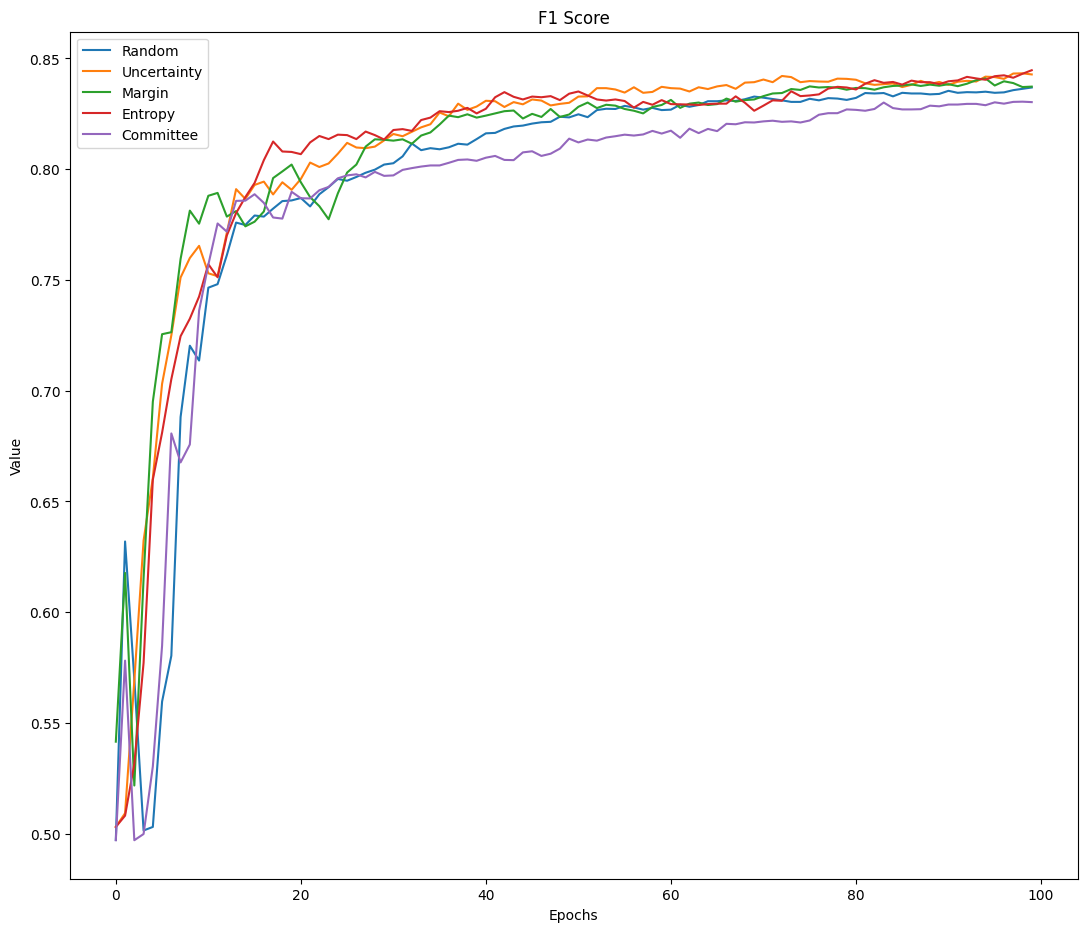

Random: 0.836899995803833
Uncertainty: 0.8428000211715698
Margin: 0.8373000621795654
Entropy: 0.844700038433075
Committee: 0.830299973487854


In [35]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["F1 Score"], label="Random")
plt.plot(results_uncertainty_sampling["F1 Score"], label="Uncertainty")
plt.plot(results_margin_sampling["F1 Score"], label="Margin")
plt.plot(results_entropy_sampling["F1 Score"], label="Entropy")
plt.plot(results_committee_sampling["F1 Score"], label="Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("F1 Score")
plt.legend()
plt.savefig("reports/model_after_al_f1_score.png")
plt.show()

print(f"Random: {results_random_sampling['F1 Score'][-1]}")
print(f"Uncertainty: {results_uncertainty_sampling['F1 Score'][-1]}")
print(f"Margin: {results_margin_sampling['F1 Score'][-1]}")
print(f"Entropy: {results_entropy_sampling['F1 Score'][-1]}")
print(f"Committee: {results_committee_sampling['F1 Score'][-1]}")